# Topic Modeling Yelp Reviews By Sentiment
Capstone Project 2 - Miguel Montano

### Problem Statement:
I propose an approach that utilizes the existing rating system in Yelp reviews to infer sentiment, attributing low and high ratings to negative and positive sentiment respectively, and creating a Latent Dirichlet Allocation (LDA) topic model for each set, extracting topics that are being discussed when users write reviews with strong opinions. A scikit-learn pipeline will be constructed to streamline the review extraction, text processing, and LDA steps, creating a topic model customizable to the client’s interests.

### Background:
Latent Dirichlet Allocation (LDA) is a ‘generative probabilistic model’, seeking to allow sets of observations to be described by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word’s presence is attributable to one of the document’s topics. In this case the documents are the reviews and the parts are the words and/or phrases (n-grams), with LDA serving as way of soft clustering the documents and parts. The fuzzy memberships drawn provide a more nuanced way of inferring topics, as each review can be made up of a combination of topics, versus simply attributing each review to one topic. This feature of LDA is key in this instance, as we are seeking to draw out terms indicative of constructive comments, with the assumption that customers might write about more than one topic in their reviews.

### Dataset:
Data has been acquired from an online posting on Kaggle containing a subset of Yelp’s business, review, and user data. It was originally assembled for the Yelp Dataset Challenge, and I will primarily be utilizing the reviews themselves grouped by categorical tags and star rating. Additional sets will be used for reference, one with North American country province/state names and abbreviations, and another provided by Yelp housing the taxonomy of the categorical tags, utilized as a resource in the grouping process.

# Table of Contents
***
* [Initialization](#Initialization)
    - [Load Packages](#Load-Packages)
    - [Import Yelp Datasets](#Import-Yelp-Datasets)
***
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Business Profiles](#Business-Profiles)
         - [Top States](#Top-States)
             - [Location](#Location-of-Businesses-in-the-Top-States)
             - [Business Count and Average Star Rating](#Business-Count-and-Average-Star-Rating)
             - [Average Number of Reviews Per Star Rating](#Average-Number-of-Reviews-Per-Star-Rating)
             - [Distribution of Star Ratings](#Distribution-of-Star-Ratings-for-Top-States)
    - [Categories](#Categories)
    - [Food Industry](#Food-Industry)
        - [Business Profiles](#Food-Industry-Business-Profiles)
        - [Reviews](#Food-Industry-Reviews)
            - [Average Star Rating Per Year](#Average-Food-Industry-Star-Rating-Per-Year)
***
* [Data Wrangling](#Data-Wrangling)
    - [Text Preprocessing](#Text-Preprocessing)
        - [Average Length of Reviews Per Star Rating](#Average-Length-of-Food-Industry-Reviews-Per-Star-Rating)
        - [Distribution of Review Lengths By Year](#Distribution-of-Review-Lengths-By-Year-for-the-Food-Industry)
    - [Split Reviews By Sentiment](#Split-Reviews-by-Sentiment)
    - [Feature Extraction](#Feature-Extraction)
        - [Dictionary](#Dictionaries)
        - [Bag-of-Words Corpus](#Bag-of-Words-Corpora)
***
* [Baseline Model](#Baseline-Model)
    - [Training](#Latent-Dirichlet-Allocation-Model)
    - [Results](#Baseline-Results)
        - [Topics](#Baseline---Topics)
        - [Negative Model Visualization](#Baseline---Negative-Unigrams-pyLDAvis)
        - [Positive Model Visualization](#Baseline---Positive-Unigrams-pyLDAvis)
        - [Summary](#Baseline---Summary)
***
* [LDA Pipeline](#LDA-Pipeline)
    - [Construction](#Custom-Transformers-and-Estimators)
        - [Yelp Review Selector](#Yelp-Review-Selector)
        - [Preprocess](#Preprocess)
        - [Vectorize](#Vectorize)
        - [LDA Estimator](#LDA-Estimator)
        - [LDA Metrics](#LDA-Metrics)
    - [Individual Business Example](#LDA-Pipeline---Random-Individual-Business)
        - [Negative Reviews Results](#LDA-Pipeline---Random-Individual-Business---Negative-Review-Results)
        - [Positive Reviews Results](#LDA-Pipeline---Random-Individual-Business---Positive-Review-Results)
    - [Food Industry Example](#LDA-Pipeline---Food-Industry)
        - [Negative Reviews Results](#LDA-Pipeline---Food-Industry---Negative-Review-Results)
        - [Positive Reviews Results](#LDA-Pipeline---Food-Industry---Positive-Review-Results)

# Initialization

### Load Packages

In [15]:
import gensim
import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, TfidfModel
from gensim.models.ldamodel import LdaModel
from gensim.models.phrases import Phrases, Phraser
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from itertools import zip_longest
from matplotlib import colors, colorbar
from nltk.stem import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
%matplotlib inline
pyLDAvis.enable_notebook()
sns.set(color_codes=True)
sns.set_context('notebook')

### Import Yelp Datasets
From: 
- https://www.kaggle.com/yelp-dataset/yelp-dataset
- https://www.yelp.com/developers/documentation/v3/all_category_list
- https://gist.github.com/pbojinov/a87adf559d2f7e81d86ae67e7bd883c7

In [2]:
'''open file containing yelp reviews into JsonReader object
    - houses total dataset split into DataFrames with at most 100,000 rows each
    - unpack into list to assist in readability of future calculations
'''
#open file containing yelp reviews as JsonReader object housing dataframe chunks
all_reviews = pd.read_json(r'C:\Users\mm183\Documents\Springboard\CP2\yelp_data\yelp_academic_dataset_review.json',
                           lines=True, chunksize = 100000)

#unpack JsonReader object into list of DataFrames
review_chunks = [c for c in all_reviews]

#open files containing yelp business profiles
businesses = pd.read_json(r'C:\Users\mm183\Documents\Springboard\CP2\yelp_data\yelp_academic_dataset_business.json',
                          lines=True)

#open file containing US/Canada Province and State abbreviation/name
us_can_province_codes = pd.read_json(r'C:\Users\mm183\Documents\Springboard\CP2\countries_and_states.json')

#open file containing yelp categories 
categories = pd.read_json(r'C:\Users\mm183\Documents\Springboard\CP2\yelp_data\categories.json')

# Exploratory Data Analysis
- [Business Profiles](#Business-Profiles)
    - [Top States](#Top-States)
        - [Location](#Location-of-Businesses-in-the-Top-States)
        - [Business Count and Average Star Rating](#Business-Count-and-Average-Star-Rating)
        - [Average Number of Reviews Per Star Rating](#Average-Number-of-Reviews-Per-Star-Rating)
        - [Distribution of Star Ratings for Top States](#Distribution-of-Star-Ratings-for-Top-States)
- [Categories](#Categories)
- [Food Industry](#Food-Industry)
    - [Business Profiles](#Food-Industry-Business-Profiles)
    - [Reviews](#Food-Industry-Reviews)
        - [Average Star Rating Per Year](#Average-Food-Industry-Star-Rating-Per-Year)
***
[Top](#Table-of-Contents)

## Business Profiles
***
[Top](#Table-of-Contents)

In [3]:
#view businesses dataframe index/column summary and memory usage
print('BUSINESSES OVERVIEW\n')
print(businesses.info())

#View total number of reviews in dataset
total_reviews = sum([len(i) for i in review_chunks])
print('\nTotal Reviews in Yelp Academic Dataset: {}'.format(total_reviews))

#view total number and percentage of reviews from businesses with profiles
print('\nTotal Reviews accounted for in businesses dataframe: {0} ({1:.3f}%)'\
      .format(businesses.review_count.sum(),
              (businesses.review_count.sum() / total_reviews) * 100))

#view summary of central tendency, dispersion, and shape of businesses data
print('\nDescriptive Statistics:')
print(businesses.describe())

#view first five rows
businesses.head()

BUSINESSES OVERVIEW

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188593 entries, 0 to 188592
Data columns (total 15 columns):
address         188593 non-null object
attributes      162807 non-null object
business_id     188593 non-null object
categories      188052 non-null object
city            188593 non-null object
hours           143791 non-null object
is_open         188593 non-null int64
latitude        188587 non-null float64
longitude       188587 non-null float64
name            188593 non-null object
neighborhood    188593 non-null object
postal_code     188593 non-null object
review_count    188593 non-null int64
stars           188593 non-null float64
state           188593 non-null object
dtypes: float64(3), int64(2), object(10)
memory usage: 21.6+ MB
None

Total Reviews in Yelp Academic Dataset: 5996996

Total Reviews accounted for in businesses dataframe: 5996750 (99.996%)

Descriptive Statistics:
             is_open       latitude      longitude   review_count  

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,1314 44 Avenue NE,"{'BikeParking': 'False', 'BusinessAcceptsCredi...",Apn5Q_b6Nz61Tq4XzPdf9A,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",Calgary,"{'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0'...",1,51.091813,-114.031675,Minhas Micro Brewery,,T2E 6L6,24,4.0,AB
1,,"{'Alcohol': 'none', 'BikeParking': 'False', 'B...",AjEbIBw6ZFfln7ePHha9PA,"Chicken Wings, Burgers, Caterers, Street Vendo...",Henderson,"{'Friday': '17:0-23:0', 'Saturday': '17:0-23:0...",0,35.960734,-114.939821,CK'S BBQ & Catering,,89002,3,4.5,NV
2,1335 rue Beaubien E,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",O8S5hYJ1SMc8fA4QBtVujA,"Breakfast & Brunch, Restaurants, French, Sandw...",MontrÃ©al,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC
3,211 W Monroe St,None,bFzdJJ3wp3PZssNEsyU23g,"Insurance, Financial Services",Phoenix,None,1,33.449999,-112.076979,Geico Insurance,,85003,8,1.5,AZ
4,2005 Alyth Place SE,{'BusinessAcceptsCreditCards': 'True'},8USyCYqpScwiNEb58Bt6CA,"Home & Garden, Nurseries & Gardening, Shopping...",Calgary,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,51.035591,-114.027366,Action Engine,,T2H 0N5,4,2.0,AB


### Top States
- [Location](#Location-of-Businesses-in-the-Top-States)
- [Business Count and Average Star Rating](#Business-Count-and-Average-Star-Rating)
- [Average Number of Reviews Per Star Rating](#Average-Number-of-Reviews-Per-Star-Rating)
- [Distribution of Star Ratings for Top States](#Distribution-of-Star-Ratings-for-Top-States)
***
[Top](#Table-of-Contents)

In [4]:
#view US & Canada state/province codes dataframe
us_can_province_codes

,abbreviation,name,states
0,US,United States,"[{'name': 'Alabama', 'abbreviation': 'AL'}, {'..."
1,CA,Canada,"[{'name': 'Alberta', 'abbreviation': 'AB'}, {'..."


In [5]:
#make dictionary of state/province codes and names
codes_dict = pd.concat([pd.DataFrame(us_can_province_codes.states[0]
                                     ).set_index('abbreviation',
                                                 drop=True),
                        pd.DataFrame(us_can_province_codes.states[1]
                                     ).set_index('abbreviation',
                                                 drop=True)]
                       ).to_dict()['name']


#map dictionary to state column to create state_name column
businesses.loc[:,'State_Name'] = businesses['state'].map(codes_dict,
                                                         na_action='ignore')

#create dataframe of businesses in top 10 states
top_states = businesses[businesses.State_Name\
                                  .isin(businesses.State_Name\
                                                  .value_counts()[:10]\
                                                  .index.tolist())]

#view top_states dataframe index/column summary and memory usage
print('TOP STATES OVERVIEW\n')
print(top_states.info())

#view top ten states
print('\nTop 10 States: ')
for i, state in enumerate(top_states.State_Name.value_counts().index.tolist()):
    print('{}. {}'.format(i+1, state))

#view top ten cities
print('\nTop 10 Cities: ')
for i, city in enumerate(businesses.city.value_counts()[:10].index.tolist()):
    print('{}. {}'.format(i+1, city))
    
#view total number and percentage of reviews from businesses in top 10 states
print('\nTotal Reviews accounted for in top_states dataframe: {} ({:.3f}%)'\
      .format(top_states.review_count.sum(),
             (top_states.review_count.sum() / total_reviews) * 100))

#view percentage of businesses from top_states in businesses data
print('\n% of Total Businesses in Top 10 States: {:.2f}%'\
      .format((len(top_states) / len(businesses)) * 100))

#view summary of central tendency, dispersion, and shape of top_states 
print('\nDescriptive Statistics:')
print(top_states.describe())

#view first five rows of top_states dataframe
top_states.head()

TOP STATES OVERVIEW

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186970 entries, 0 to 188592
Data columns (total 16 columns):
address         186970 non-null object
attributes      161457 non-null object
business_id     186970 non-null object
categories      186434 non-null object
city            186970 non-null object
hours           142809 non-null object
is_open         186970 non-null int64
latitude        186964 non-null float64
longitude       186964 non-null float64
name            186970 non-null object
neighborhood    186970 non-null object
postal_code     186970 non-null object
review_count    186970 non-null int64
stars           186970 non-null float64
state           186970 non-null object
State_Name      186970 non-null object
dtypes: float64(3), int64(2), object(11)
memory usage: 24.2+ MB
None

Top 10 States: 
1. Arizona
2. Nevada
3. Ontario
4. North Carolina
5. Ohio
6. Pennsylvania
7. Quebec
8. Alberta
9. Wisconsin
10. Illinois

Top 10 Cities: 
1. Las Vegas
2. Pho

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,State_Name
0,1314 44 Avenue NE,"{'BikeParking': 'False', 'BusinessAcceptsCredi...",Apn5Q_b6Nz61Tq4XzPdf9A,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",Calgary,"{'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0'...",1,51.091813,-114.031675,Minhas Micro Brewery,,T2E 6L6,24,4.0,AB,Alberta
1,,"{'Alcohol': 'none', 'BikeParking': 'False', 'B...",AjEbIBw6ZFfln7ePHha9PA,"Chicken Wings, Burgers, Caterers, Street Vendo...",Henderson,"{'Friday': '17:0-23:0', 'Saturday': '17:0-23:0...",0,35.960734,-114.939821,CK'S BBQ & Catering,,89002,3,4.5,NV,Nevada
2,1335 rue Beaubien E,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",O8S5hYJ1SMc8fA4QBtVujA,"Breakfast & Brunch, Restaurants, French, Sandw...",MontrÃ©al,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC,Quebec
3,211 W Monroe St,None,bFzdJJ3wp3PZssNEsyU23g,"Insurance, Financial Services",Phoenix,None,1,33.449999,-112.076979,Geico Insurance,,85003,8,1.5,AZ,Arizona
4,2005 Alyth Place SE,{'BusinessAcceptsCreditCards': 'True'},8USyCYqpScwiNEb58Bt6CA,"Home & Garden, Nurseries & Gardening, Shopping...",Calgary,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,51.035591,-114.027366,Action Engine,,T2H 0N5,4,2.0,AB,Alberta


#### Location of Businesses in the Top States
***
[Top](#Table-of-Contents)

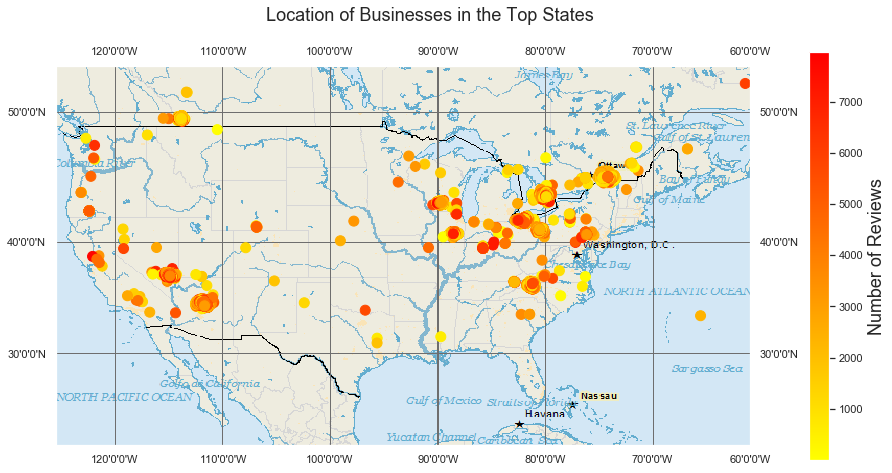

In [6]:
'''account for inconsistencies in reporting of coordinate values
    - latitude should be positive for top states, which are located North
    - longitude should be negative for top states, which are located West
    - remove outliers, which would not feasibly correspond to a state
    - drop entries with undefined values
'''
def clean_coordinates(df):
    state_latitude = []
    state_longitude = []
    for s in df.state.unique():
        for c in ['latitude', 'longitude']:
            if s in top_states.State_Name.unique():
                s_c = df.loc[df['state'] == s, c]\
                        .apply(lambda x: np.sqrt(x ** 2))
                s_c = s_c[np.abs(s_c - s_c.mean()) <= (3 * s_c.std())]
                if c == 'longitude':
                    state_longitude.append(s_c.apply(lambda x: x * -1))
                else: 
                    state_latitude.append(s_c)
            elif c == 'longitude':
                state_longitude.append(df.loc[df['state'] == s, c])
            else:
                state_latitude.append(df.loc[df['state'] == s, c])
    return df.drop(['latitude', 'longitude'], axis=1)\
             .join(pd.DataFrame({'latitude': pd.concat(state_latitude),
                                 'longitude': pd.concat(state_longitude)}),
                   how='inner')

#clean coordinates in businesses dataframe
businesses = clean_coordinates(businesses)

#create color map using review count per business to determine hue
color_by_review_count = {id: color for id, color
                         in zip(businesses.sort_values('review_count')
                                          .business_id,
                                sns.color_palette('autumn_r',
                                                  len(businesses)))}

#create color column by mapping color_by_review_count dict to business_id
businesses.loc[:, 'color'] = businesses.business_id.map(color_by_review_count)

'''plot coordinates on map of north america
    - with color as the number of reviews in each business
'''
sns.set_style('dark')
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(businesses.longitude, businesses.latitude,
           c=businesses.color, s=100)
ax.imshow(plt.imread("Mercator-North-America.png"),
          extent=[-126, -60, 20, 56])
ax.set(xticks=[-120.4, -110.1, -100, -89.7, -79.5, -69.3, -60],
       xticklabels=[str(i)[1:]+"'0'0'W" for i in np.arange(-120, -50, 10)],
       yticks=[20, 28.7, 39.3, 51.7],
       yticklabels=['', "30'0'0'N", "40'0'0'N", "50'0'0'N"])
ax.tick_params('x', labelbottom=True, labeltop=True)
ax.tick_params('y', labelleft=True, labelright=True)
cax, _ = colorbar.make_axes(ax, location='right', fraction=0.1,
                            pad=0.07, shrink=0.5)
cbar = colorbar.ColorbarBase(cax, cmap=plt.cm.autumn_r,
                             norm=colors.Normalize(vmin=businesses.review_count\
                                                                  .min(),
                                                   vmax=businesses.review_count\
                                                                  .max()))
cbar.set_label('Number of Reviews', fontsize=18)
fig.text(0.32, 0.72, 'Location of Businesses in the Top States', fontsize=18);

#### Business Count and Average Star Rating
***
[Top](#Table-of-Contents)

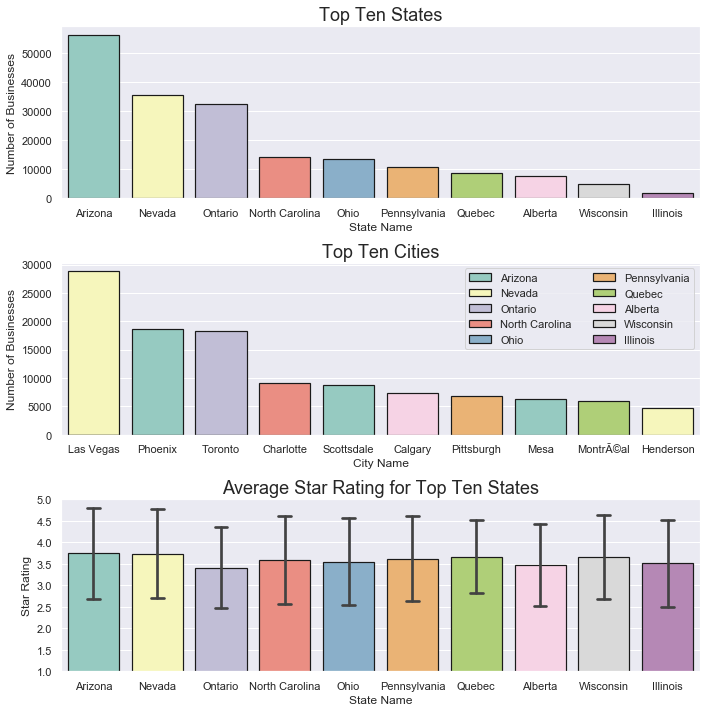

In [7]:
'''- plot number of businesses in each of the top 10 states
   - plot number of businesses in each of the top 10 cities, colored by state
   - plot average star rating for each of the top 10 states, capped with standard deviation
'''
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows=3, figsize=(10, 10))
sns.countplot(x='State_Name', data=top_states,
              order=top_states.State_Name.value_counts().index.tolist(),
              linewidth=1.2, edgecolor='k', palette='Set3', ax=axes[0])
sns.countplot(x='city', hue='State_Name', dodge=False,
              data=top_states[top_states.city.isin(top_states.city\
                                                             .value_counts()[:10]\
                                                             .index.tolist())],
              hue_order=top_states.State_Name.value_counts().index.tolist(),
              order=top_states.city.value_counts()[:10].index.tolist(),
              linewidth=1.2, edgecolor='k', palette='Set3', ax=axes[1])
sns.barplot(x='State_Name', y='stars', data=top_states,
            order=top_states.State_Name.value_counts().index.tolist(),
            ci='sd', capsize=0.2, palette='Set3',
            linewidth=1.2, edgecolor='k', ax=axes[2])
axes[0].set_title('Top Ten States', fontsize=18)
axes[0].set(xlabel='State Name', ylabel='Number of Businesses')
axes[1].set_title('Top Ten Cities', fontsize=18)
axes[1].set(xlabel='City Name', ylabel='Number of Businesses')
axes[1].legend(loc='upper right', ncol=2)
axes[2].set_title('Average Star Rating for Top Ten States', fontsize=18)
axes[2].set(xlabel='State Name', ylabel='Star Rating', 
            ylim=(1,5), yticks=np.arange(1, 5.5, 0.5))
plt.tight_layout();

#### Average Number of Reviews Per Star Rating
***
[Top](#Table-of-Contents)

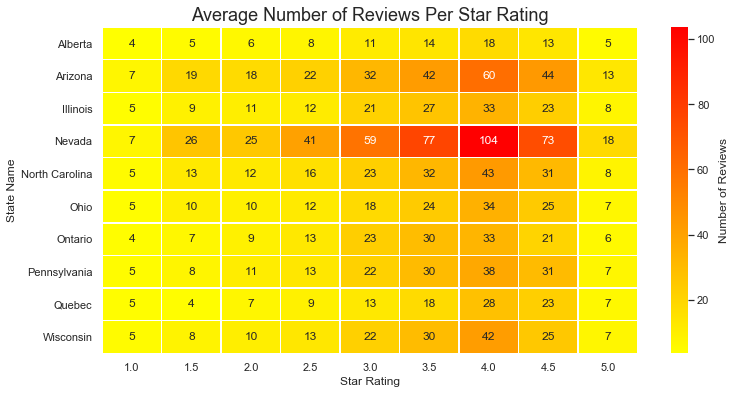

In [17]:
#plot the average number of reviews per star rating for the top states
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pd.pivot_table(top_states, aggfunc=np.mean,
                           values='review_count', index='State_Name', columns='stars'),
            cmap=plt.cm.autumn_r, cbar_kws={'label': 'Number of Reviews'},
            annot=True, fmt='.0f', linewidths=0.5, ax=ax)
ax.set_title('Average Number of Reviews Per Star Rating', fontsize=18)
ax.set(xlabel='Star Rating', ylabel='State Name');

#### Distribution of Star Ratings for Top States
***
[Top](#Table-of-Contents)

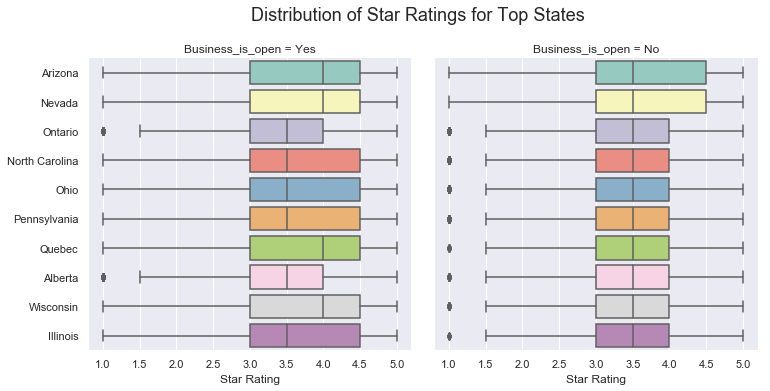

In [9]:
#create 'Business_is_open' column by mapping strings to values from 'is_open' column 
top_states = top_states.assign(Business_is_open=top_states.is_open\
                                                          .map({0: 'No', 1: 'Yes'}))

#plot distribution of star ratings for businesses in the top states
sns.set_style('darkgrid')
ax = sns.catplot(x='stars', y='State_Name', col='Business_is_open',
                 order=top_states.State_Name.value_counts().index.tolist(),
                 data=top_states, kind='box', palette='Set3', height=5.5)
ax.set(xlabel='Star Rating', ylabel='', xticks=np.arange(1, 5.5, 0.5))
plt.subplots_adjust(top=0.85)
ax.fig.suptitle('Distribution of Star Ratings for Top States',
                x=0.55, fontsize=18);

## Categories
***
[Top](#Table-of-Contents)

In [10]:
#view categories dataframe index/column summary and memory usage
print('CATEGORIES OVERVIEW\n')
print(categories.info())
print(categories.head())

#view number of unique parent categories
parents = sorted([c for c in set([c[0] for c in categories.parents if c])])
print('\nNumber of Unique Parent Tags: {}'.format(len(parents)))

#view parent categories
print('\nParent Tags for Yelp Categories:\n')
for q1, q2, q3, q4 in zip_longest(parents[:30], parents[30:60],
                                  parents[60:90], parents[90:], fillvalue=''):
    print('{:<25}{:<25}{:<25}{}'.format(q1, q2, q3, q4))

CATEGORIES OVERVIEW

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1539 entries, 0 to 1538
Data columns (total 5 columns):
alias                1539 non-null object
country_blacklist    349 non-null object
country_whitelist    518 non-null object
parents              1539 non-null object
title                1539 non-null object
dtypes: object(5)
memory usage: 60.2+ KB
None
          alias         country_blacklist country_whitelist          parents  \
0    3dprinting                       NaN               NaN  [localservices]   
1     abruzzese                       NaN              [IT]        [italian]   
2  absinthebars                       NaN              [CZ]           [bars]   
3     acaibowls  [MX, PL, TR, AR, CL, IT]               NaN           [food]   
4   accessories                       NaN               NaN        [fashion]   

           title  
0    3D Printing  
1      Abruzzese  
2  Absinthe Bars  
3     Acai Bowls  
4    Accessories  

Number of Unique Parent

## Food Industry
- [Business Profiles](#Food-Industry-Business-Profiles)
- [Reviews](#Food-Industry-Reviews)
    - [Average Star Rating Per Year](#Average-Food-Industry-Star-Rating-Per-Year)
***
[Top](#Table-of-Contents)

### Food Industry Business Profiles

In [11]:
#create list of parent tags pertaining to food-related businesses
food_categories = ['bars','breweries','cafes','donburi','food',
                   'gourmet','localflavor','restaurants','wineries']

#create list of all tags that have food categories as their parent tag
food_tags = categories.iloc[[index for index, parent in categories.parents.items()
                             if any(tag in food_categories for tag in parent)]]\
                      .title.str.lower().tolist()

#create mask for businesses with food-related category tags
food_mask = [any(category in tags for category in food_tags)
             if tags else False
             for (index, tags) in businesses.categories\
                                            .str.lower().str.split(', ')\
                                            .items()]

#create dataframe of businesses pertaining to the food industry
food_industry = businesses[food_mask]

#view food_industry dataframe index/column summary and memory usage
print('FOOD INDUSTRY OVERVIEW\n')
print(food_industry.info())

#view top ten food tags
print('\nTop 10 Food Tags: ')
for i, tag in enumerate(pd.Series([tag for tag_list in
                                   food_industry.categories.str.split(', ').tolist()
                                   for tag in tag_list]).value_counts()[:10]\
                                                        .index.tolist()):
    print('{}. {}'.format(i+1, tag))

#view summary of central tendency, dispersion, and shape for the food_industry
print('\nDescriptive Statistics:')
print(food_industry.describe())

FOOD INDUSTRY OVERVIEW

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73536 entries, 0 to 188590
Data columns (total 17 columns):
address         73536 non-null object
attributes      71567 non-null object
business_id     73536 non-null object
categories      73536 non-null object
city            73536 non-null object
hours           55299 non-null object
is_open         73536 non-null int64
name            73536 non-null object
neighborhood    73536 non-null object
postal_code     73536 non-null object
review_count    73536 non-null int64
stars           73536 non-null float64
state           73536 non-null object
State_Name      73144 non-null object
latitude        73535 non-null float64
longitude       73536 non-null float64
color           73536 non-null object
dtypes: float64(3), int64(2), object(12)
memory usage: 10.1+ MB
None

Top 10 Food Tags: 
1. Restaurants
2. Food
3. Nightlife
4. Bars
5. Coffee & Tea
6. Sandwiches
7. Fast Food
8. American (Traditional)
9. Pizza
10. Burg

### Food Industry Reviews
- [Average Star Rating Per Year](#Average-Food-Industry-Star-Rating-Per-Year)
***
[Top](#Table-of-Contents)

In [12]:
#create DataFrame of reviews from the food industry with at least 200 reviews
food_reviews = pd.concat([c.loc[c.business_id\
                                .isin(food_industry[food_industry.review_count >= 200
                                                    ].business_id.tolist())] 
                         for c in review_chunks]).sort_values('date').reset_index(drop=True)

In [13]:
#view food_reviews dataframe index/column summary and memory usage
print('FOOD REVIEWS OVERVIEW\n')
print(food_reviews.info())


#view summary of central tendency, dispersion, and shape for food_reviews
print('\nDescriptive Statistics:')
display(food_reviews[['stars','cool','funny','useful']].groupby('stars')\
                                                       .agg(['mean','std','min', 'max','count'])\
                                                       .apply(lambda x: round(x,3)))

FOOD REVIEWS OVERVIEW

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1905325 entries, 0 to 1905324
Data columns (total 9 columns):
business_id    object
cool           int64
date           datetime64[ns]
funny          int64
review_id      object
stars          int64
text           object
useful         int64
user_id        object
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 130.8+ MB
None

Descriptive Statistics:


cool                          funny                         useful  \
        mean    std min  max   count   mean    std min  max   count   mean   
stars                                                                        
1      0.307  2.144   0  505  162220  0.727  3.710   0  637  162220  1.610   
2      0.428  1.872   0  172  157849  0.636  2.178   0  274  157849  1.398   
3      0.634  2.603   0  245  241866  0.579  2.849   0  435  241866  1.201   
4      0.838  3.130   0  229  512665  0.556  3.094   0  566  512665  1.202   
5      0.608  2.322  -1  208  830725  0.371  3.240   0  991  830725  0.910   

                                
         std min   max   count  
stars                           
1      8.598   0  1118  162220  
2      5.250   0  1234  157849  
3      3.741   0   805  241866  
4      3.509   0   245  512665  
5      2.707  -1   215  830725

#### Average Food Industry Star Rating Per Year
***
[Top](#Table-of-Contents)

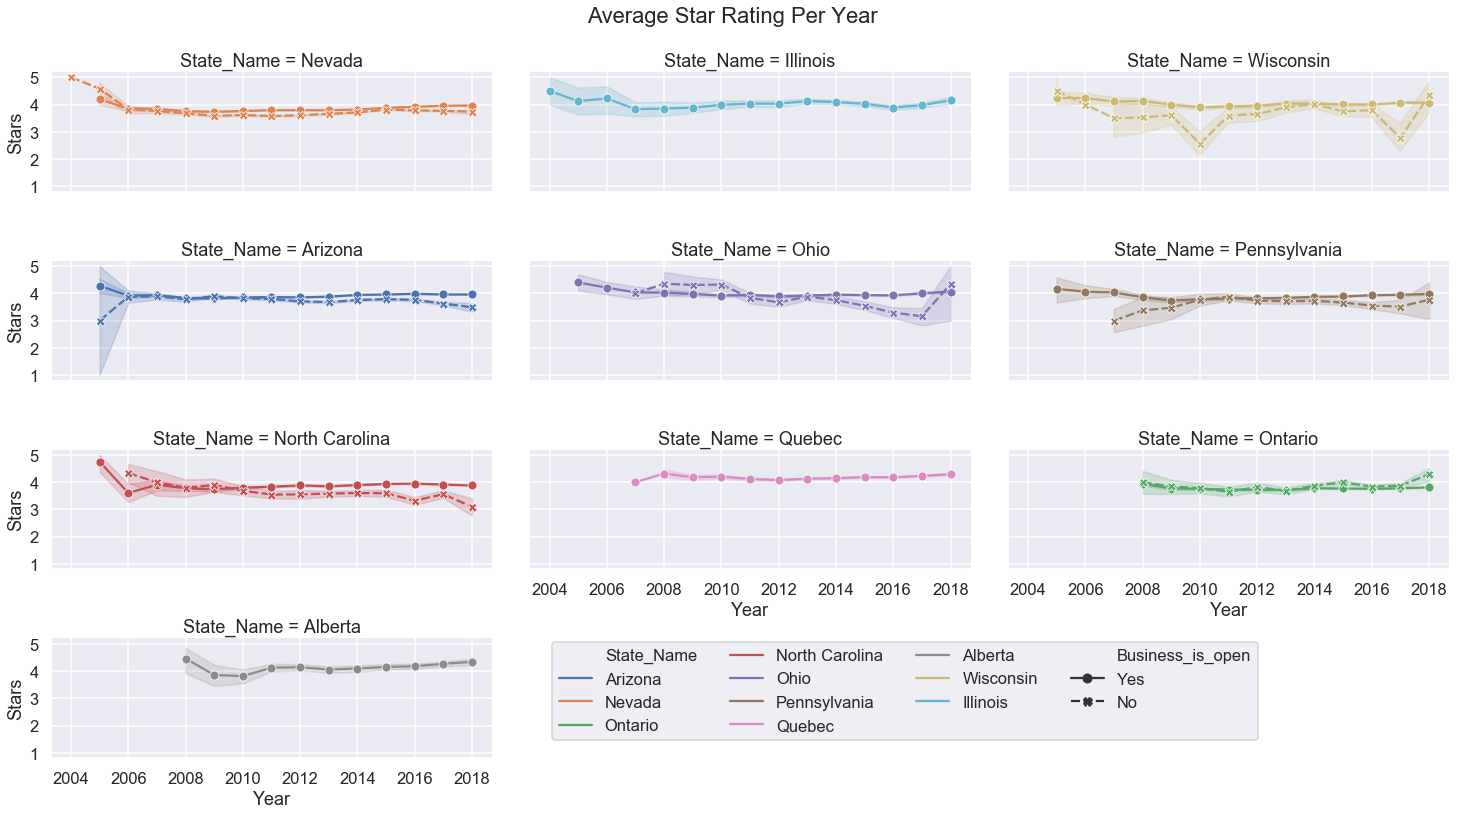

In [294]:
#add the year the review was posted as a column in food_reviews dataframe
food_reviews['year'] = food_reviews.date.dt.year

#merge food_reviews and top_states on business_id to add State_Name and Business_is_open columns
food_reviews = pd.merge(left=food_reviews, 
                        right=top_states[['business_id',
                                          'State_Name',
                                          'Business_is_open']],
                        on='business_id')

#plot the average food industry star rating per year for each of the top states
sns.set_style('darkgrid')
sns.set_context('talk')
g = sns.relplot(x='year', y='stars', kind='line', hue='State_Name', 
                hue_order=top_states.State_Name.value_counts().index.tolist(),
                col='State_Name', col_wrap=3, style='Business_is_lopen', 
                style_order=['Yes','No'], markers=True,
                height=3, aspect=2, data=food_reviews)             
g.set(xlabel='Year',ylabel='Stars', yticks=np.arange(1,6,1, dtype='int'),
      xticks=np.arange(food_reviews.year.min(),
                       food_reviews.year.max()+1, 2, dtype='int'))
g.fig.legend(handles=g._legend_data.values(), labels=g._legend_data.keys(),
             bbox_to_anchor=[0.85,0.21], ncol=4)
g.fig.get_children()[-2].set_visible(False)
plt.suptitle('Average Star Rating Per Year', fontsize=22)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

# Data Wrangling
- [Text Preprocessing](#Text-Preprocessing)
    - [Average Length of Reviews Per Star Rating](#Average-Length-of-Food-Industry-Reviews-Per-Star-Rating)
    - [Distribution of Review Lengths By Year](#Distribution-of-Review-Lengths-By-Year-for-the-Food-Industry)
- [Split Reviews By Sentiment](#Split-Reviews-by-Sentiment)
- [Feature Extraction](#Feature-Extraction)
    - [Dictionary](#Dictionaries)
    - [Bag-of-Words Corpus](#Bag-of-Words-Corpora)
***
[Top](#Table-of-Contents)

## Text Preprocessing
- Tokenization: 
<br>Remove punctuation/special characters and transform passages from one long string into lists of word strings
- Normalization: 
<br>Convert all text to lower case, expand contractions, remove numerals and accent marks
- Stopwords Removal: 
<br>Remove words below three characters, and those which contribute little to overall meaning
- Lemmatization: 
<br>Eliminate affixes from a word by capturing the canonical forms based on a word's lemma, or chosen representative,
<br>in this case assigning a Verb category tag to the tokenized parts of a sentence
***
[Top](#Table-of-Contents)

In [14]:
#define function to preprocess review text
def preprocess(text):
    tokens = []
    for token in simple_preprocess(text, deacc=True):
        if token not in STOPWORDS and len(token) > 3:
            tokens.append(WordNetLemmatizer().lemmatize(token, pos='v'))
    return tokens

#preprocess reviews
food_reviews['tokens'] = food_reviews.text.apply(preprocess)

#### Average Length of Food Industry Reviews Per Star Rating
***
[Top](#Table-of-Contents)

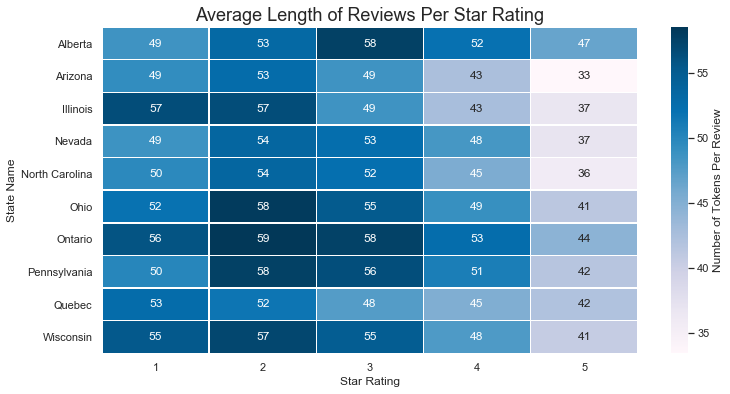

In [19]:
#add length of tokenized reviews as column to food_reviews
food_reviews['review_length'] = food_reviews.tokens.apply(len)

#plot average length of reviews per star rating for the top states
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pd.pivot_table(food_reviews, aggfunc=np.mean,
                           values='review_length', index='State_Name', columns='stars'),
            annot=True, fmt='.0f', linewidths=0.5, ax=ax, cmap=plt.cm.PuBu,
            cbar_kws={'label': 'Number of Tokens Per Review'})
ax.set_title('Average Length of Reviews Per Star Rating', fontsize=18)
ax.set(xlabel='Star Rating', ylabel='State Name');

#### Distribution of Review Lengths By Year for the Food Industry
***
[Top](#Table-of-Contents)

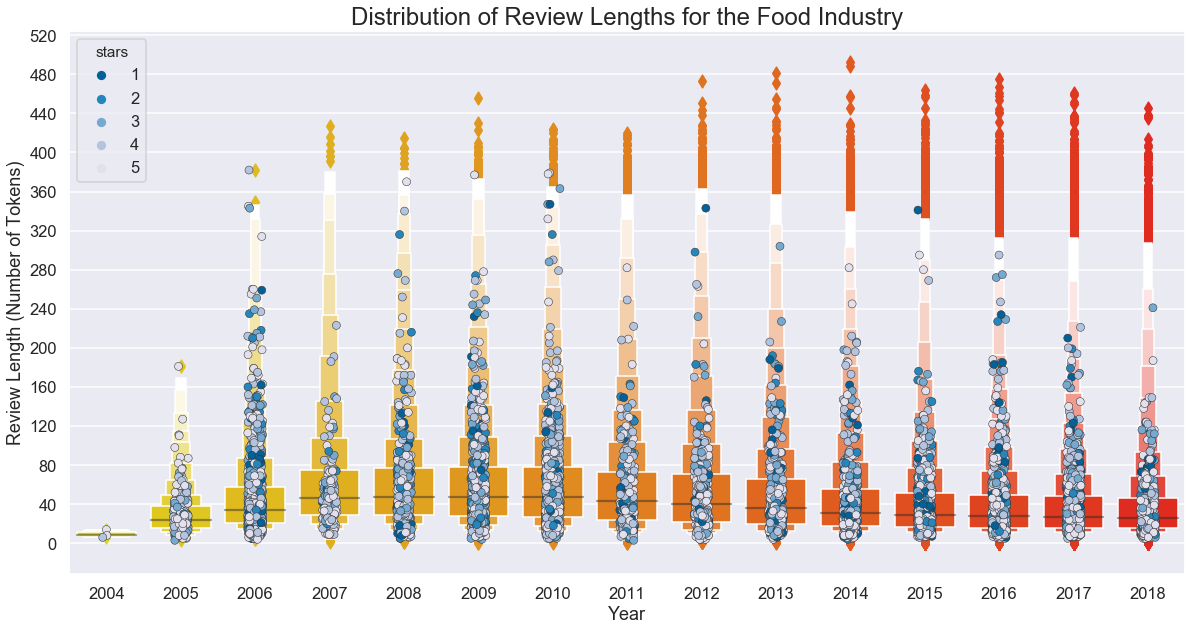

In [233]:
'''plot distribution of review lengths for the food industry
    - letter-value plot by year
    - overlay with review length data points colored by star rating given in review
    - only plot a subset of < 10,000 points to assist in visibility
'''
#sort food_reviews by year
food_reviews = food_reviews.sort_values('year')

#plot review length distribution by year
sns.set_context('talk')
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20,10))
sns.stripplot(y='review_length', x='year', hue='stars', ax=ax,
              jitter=True, linewidth=0.5, size=8, palette='PuBu_r',
              data=pd.concat([food_reviews.iloc[:1000],
                              food_reviews.iloc[1000:100000:50,:],
                              food_reviews.iloc[100000::500,:]]))
sns.boxenplot(y='review_length', x='year', data=food_reviews, ax=ax,
              palette='autumn_r', k_depth='proportion', scale='area', linewidth=1)
ax.set_title('Distribution of Review Lengths for the Food Industry', fontsize=24)
ax.set(xlabel='Year', ylabel='Review Length (Number of Tokens)',
       yticks=np.arange(0, food_reviews.review_length.max()+40, 40));

## Split Reviews by Sentiment
Inferred from star ratings provided by reviewers, assuming ratings correlate to strength of sentiment
- As there are a lot of food industry reviews, neutral ('3') star reviews will be ignored:
    - considered 'negative' if rated 1, 2 stars
    - considered 'positive' if rated 4, 5 stars
***
[Top](#Table-of-Contents)

In [100]:
#split food_reviews by sentiment inferred from rating
negative_reviews = food_reviews[food_reviews.stars < 3]
positive_reviews = food_reviews[food_reviews.stars > 3]

#show more characters per column
pd.options.display.max_colwidth = 100

print('Negative Food Industry Reviews\n')
print(negative_reviews.info())
display(negative_reviews.text.tail())
display(negative_reviews.tokens.tail())

print('\nPositive Food Industry Reviews\n')
print(positive_reviews.info())
display(positive_reviews.text.tail())
display(positive_reviews.tokens.tail())

#revert display settings
pd.reset_option('display.max_colwidth')

Negative Food Industry Reviews

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319968 entries, 13 to 1904179
Data columns (total 14 columns):
business_id         319968 non-null object
cool                319968 non-null int64
date                319968 non-null datetime64[ns]
funny               319968 non-null int64
review_id           319968 non-null object
stars               319968 non-null int64
text                319968 non-null object
useful              319968 non-null int64
user_id             319968 non-null object
year                319968 non-null int64
State_Name          319968 non-null object
Business_is_open    319968 non-null object
tokens              319968 non-null object
review_length       319968 non-null int64
dtypes: datetime64[ns](1), int64(6), object(7)
memory usage: 36.6+ MB
None


1904080    Decor is nice but slow service, pastries were not good at all, tiramisu just ok but too thick. C...
1904091    Came in and order at 3.16 pm waited for 30 mins. Still haven't gotten our order. Hopefully next ...
1904147                  Good atmosphere and location, but the taste of the coffee and deserts are horrendous.
1904178    We traveled 30 minutes to this spot since we been here once before and wanted to come back to tr...
1904179    OVERHYPED and OVERRATED.\n\nYes it's aesthetically pleasing to the eyes. Nice greenhouse in the ...
Name: text, dtype: object

1904080    [decor, nice, slow, service, pastries, good, tiramisu, litchi, rise, pastrie, flavor, come, choo...
1904091             [come, order, wait, mins, haven, get, order, hopefully, time, come, bavk, better, service]
1904147                                        [good, atmosphere, location, taste, coffee, desert, horrendous]
1904178    [travel, minutes, spot, want, come, different, things, yelp, google, show, close, arrive, exactl...
1904179    [overhyped, overrate, aesthetically, please, eye, nice, greenhouse, middle, beautiful, victorian...
Name: tokens, dtype: object


Positive Food Industry Reviews

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1342441 entries, 0 to 1904177
Data columns (total 14 columns):
business_id         1342441 non-null object
cool                1342441 non-null int64
date                1342441 non-null datetime64[ns]
funny               1342441 non-null int64
review_id           1342441 non-null object
stars               1342441 non-null int64
text                1342441 non-null object
useful              1342441 non-null int64
user_id             1342441 non-null object
year                1342441 non-null int64
State_Name          1342441 non-null object
Business_is_open    1342441 non-null object
tokens              1342441 non-null object
review_length       1342441 non-null int64
dtypes: datetime64[ns](1), int64(6), object(7)
memory usage: 153.6+ MB
None


1904173    Friends night out and I chose Gabi Coffee and Bakery and everyone loved this place.  5 stars for...
1904174    This is a hidden gem in Las Vegas! The aesthetic and history surely creates an experience to the...
1904175    This is my favorite hang in Las Vegas!!! Because of the indoor atrium and korean decor it's like...
1904176    Little confusing to find cause of just having a big brown door and no sign. But when you walk in...
1904177    Their desserts are super cute and you can tell that the staff puts hard work into them, consider...
Name: text, dtype: object

1904173    [friends, night, choose, gabi, coffee, bakery, love, place, star, vibe, decor, ambiance, wish, h...
1904174    [hide, vegas, aesthetic, history, surely, create, experience, personal, favorite, latte, perfect...
1904175                              [favorite, hang, vegas, indoor, atrium, korean, decor, like, vegas, love]
1904176    [little, confuse, cause, have, brown, door, sign, walk, inside, like, different, little, world, ...
1904177    [desserts, super, cute, tell, staff, put, hard, work, consider, small, detail, cake, enjoy, expe...
Name: tokens, dtype: object

## Feature Extraction
- [Dictionary](#Dictionaries)
<Br>A mapping between words and their integer ids, created from the normalized tokens in each corpus (negative and positive reviews)
<Br>by sweeping across them, assigning a unique integer id to each word, then collecting word counts and relevant statistics
- [Bag-of-Words Corpus](#Bag-of-Words-Corpora)
<Br>Tokenized documents converted into vectors, by counting the number of occurrences of each distinct word, converting the word to
<Br>its integer word id, and returning the result as a sparse vector, disregarding grammar and even word order but keeping multiplicity
***
[Top](#Table-of-Contents)

### Dictionaries
- for each set of tokens

In [178]:
#create dictionaries
negative_dict = Dictionary(negative_reviews.tokens)
positive_dict = Dictionary(positive_reviews.tokens)

### Bag of Words Corpora 
- format which can be plugged into the model

In [179]:
#create bag of words corpora
negative_corpus = [negative_dict.doc2bow(text) for text in negative_reviews.tokens]
positive_corpus = [positive_dict.doc2bow(text) for text in positive_reviews.tokens]

# Baseline Model
- [Training](#Baseline---Latent-Dirichlet-Allocation-Model)
- [Results](#Baseline-Results)
    - [Topics](#Baseline---Topics)
    - [Negative Model Visualization](#Baseline---Negative-Unigrams-pyLDAvis)
    - [Positive Model Visualization](#Baseline---Positive-Unigrams-pyLDAvis)
    - [Summary](#Baseline---Summary)
***
[Top](#Table-of-Contents)

## Baseline - Latent Dirichlet Allocation Model
- Using Gensim's LdaModel module, which is streamed and runs in constant memory with respect to the number of documents;
<br>meaning training documents may come in sequentially, requiring no random access, and the size of the training corpus does not affect memory footprint
- In this case it is a unigram model as each word has been vectorized individually, ignoring context and phrasing

In [180]:
#train baseline lda models
negative_unigrams_lda = LdaModel(negative_corpus,
                                 num_topics=10,
                                 id2word=negative_dict)
positive_unigrams_lda = LdaModel(positive_corpus,
                                 num_topics=10,
                                 id2word=positive_dict)

## Baseline Results
- [Topics](#Baseline---Topics)
- [Negative Model Visualization](#Baseline---Negative-Unigrams-pyLDAvis)
- [Positive Model Visualization](#Baseline---Positive-Unigrams-pyLDAvis)
- [Summary](#Baseline---Summary)
***
[Top](#Table-of-Contents)

### Baseline - Topics

In [181]:
#define function to view top N topics in Gensim LDA model
def top_n_topics(lda_model, num_words):
    for topic, words in lda_model.print_topics(num_words=num_words):
        print('Topic: {} \nWords: {}'.format(topic, words))

In [182]:
#view topics
print('NEGATIVE LDA TOPICS')
top_n_topics(negative_unigrams_lda, 5)
print('\nPOSITIVE LDA TOPICS')
top_n_topics(positive_unigrams_lda, 5)

NEGATIVE LDA TOPICS
Topic: 0 
Words: 0.045*"food" + 0.033*"place" + 0.024*"good" + 0.023*"service" + 0.018*"price"
Topic: 1 
Words: 0.040*"order" + 0.039*"food" + 0.036*"come" + 0.031*"wait" + 0.024*"service"
Topic: 2 
Words: 0.024*"order" + 0.021*"fry" + 0.018*"burger" + 0.017*"pizza" + 0.016*"salad"
Topic: 3 
Words: 0.019*"hair" + 0.012*"movie" + 0.010*"italian" + 0.010*"asada" + 0.010*"indian"
Topic: 4 
Words: 0.028*"soup" + 0.025*"dish" + 0.022*"chicken" + 0.021*"pork" + 0.018*"order"
Topic: 5 
Words: 0.031*"table" + 0.017*"restaurant" + 0.016*"seat" + 0.012*"host" + 0.011*"party"
Topic: 6 
Words: 0.020*"like" + 0.018*"food" + 0.016*"chip" + 0.016*"order" + 0.016*"tacos"
Topic: 7 
Words: 0.024*"place" + 0.020*"like" + 0.014*"drink" + 0.011*"people" + 0.010*"look"
Topic: 8 
Words: 0.026*"food" + 0.023*"sushi" + 0.020*"buffet" + 0.017*"roll" + 0.016*"like"
Topic: 9 
Words: 0.024*"say" + 0.018*"tell" + 0.016*"order" + 0.014*"time" + 0.013*"ask"

POSITIVE LDA TOPICS
Topic: 0 
Words: 0.

### Baseline - Negative Unigrams pyLDAvis
***
[Top](#Table-of-Contents)

In [194]:
#create pyLDAvis visualizations for unigram lda models
negative_unigrams_vis = pyLDAvis.gensim.prepare(negative_unigrams_lda,
                                                negative_corpus,
                                                negative_dict)

#view negative unigrams lda topics
print('Negative LDA Model - Unigrams')
negative_unigrams_vis

Negative LDA Model - Unigrams


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.171070 -0.009998       1        1  19.953199
0      0.049672 -0.059455       2        1  14.522589
9      0.189665  0.046287       3        1  13.573816
2     -0.097214 -0.132813       4        1  11.826860
5      0.201274  0.063759       5        1  11.005690
7      0.100640  0.041842       6        1   8.155069
8     -0.050118 -0.098130       7        1   8.080164
6     -0.121010 -0.128085       8        1   6.442683
4     -0.235161 -0.124097       9        1   4.858598
3     -0.208818  0.400690      10        1   1.581329, topic_info=     Category           Freq           Term          Total  loglift  logprob
term                                                                        
195   Default  116266.000000          table  116266.000000  30.0000  30.0000
12    Default  321413.000000           food  321413.000000  29.0000  29.0000
143   Default  116905.000000           wait  116905.000000  28.0000  28.0000
101   Default  253333.000000          order  253333.000000  27.0000  27.0000
446   Default   83618.000000        minutes   83618.000000  26.0000  26.0000
325   Default   62444.000000        chicken   62444.000000  25.0000  25.0000
71    Default   85230.000000          taste   85230.000000  24.0000  24.0000
297   Default   30890.000000          sushi   30890.000000  23.0000  23.0000
558   Default   36054.000000         burger   36054.000000  22.0000  22.0000
222   Default   55479.000000            fry   55479.000000  21.0000  21.0000
192   Default   53199.000000           seat   53199.000000  20.0000  20.0000
343   Default   95797.000000          drink   95797.000000  19.0000  19.0000
215   Default   42059.000000           dish   42059.000000  18.0000  18.0000
66    Default  172576.000000        service  172576.000000  17.0000  17.0000
141   Default   98576.000000            say   98576.000000  16.0000  16.0000
590   Default   23771.000000           soup   23771.000000  15.0000  15.0000
320   Default   26866.000000         buffet   26866.000000  14.0000  14.0000
559   Default   39635.000000         cheese   39635.000000  13.0000  13.0000
196   Default   80728.000000           tell   80728.000000  12.0000  12.0000
24    Default   33292.000000          pizza   33292.000000  11.0000  11.0000
397   Default   43635.000000          sauce   43635.000000  10.0000  10.0000
396   Default   36121.000000          salad   36121.000000   9.0000   9.0000
34    Default   87502.000000            ask   87502.000000   8.0000   8.0000
27    Default   62588.000000          price   62588.000000   7.0000   7.0000
59    Default  215151.000000          place  215151.000000   6.0000   6.0000
531   Default   27676.000000          steak   27676.000000   5.0000   5.0000
484   Default   25385.000000           roll   25385.000000   4.0000   4.0000
18    Default  173860.000000           like  173860.000000   3.0000   3.0000
243   Default   26067.000000           rice   26067.000000   2.0000   2.0000
61    Default   16905.000000           pork   16905.000000   1.0000   1.0000
...       ...            ...            ...            ...      ...      ...
2157  Topic10    2048.861816         health    2051.141602   4.1458  -4.8510
5703  Topic10     728.492188      unwelcome     729.359253   4.1457  -5.8851
6524  Topic10     728.903259           slab     729.772034   4.1457  -5.8845
1324  Topic10     700.533752          wheel     701.401245   4.1457  -5.9242
9640  Topic10     667.652039          curly     668.518738   4.1456  -5.9723
5588  Topic10     661.013733           hunt     661.880493   4.1456  -5.9823
8218  Topic10     647.898621           kiss     648.765625   4.1456  -6.0023
4958  Topic10     617.064636         salsas     617.931396   4.1455  -6.0511
4461  Topic10     852.153931          italy     853.400146   4.1454  -5.7283
2518  Topic10     579.903320      violently     580.770325   4.1454  -6.113

### Baseline - Positive Unigrams pyLDAvis
***
[Top](#Table-of-Contents)

In [196]:
#create pyLDAvis visualizations for unigram lda models
positive_unigrams_vis = pyLDAvis.gensim.prepare(positive_unigrams_lda,
                                                positive_corpus,
                                                positive_dict)

#view positive unigrams lda topics
print('Positive LDA Model - Unigrams')
positive_unigrams_vis

c:\programdata\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Positive LDA Model - Unigrams


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.168310 -0.028763       1        1  18.179903
6      0.145449 -0.098954       2        1  15.930559
9     -0.115983  0.054074       3        1  13.271013
8      0.194851 -0.078388       4        1  11.296900
7      0.171789 -0.070171       5        1  10.664615
4     -0.090150  0.008247       6        1   8.849902
2     -0.035525  0.144975       7        1   6.661150
1     -0.053302  0.164486       8        1   6.184358
3     -0.045509  0.118979       9        1   6.153240
0     -0.339929 -0.214485      10        1   2.808355, topic_info=     Category           Freq        Term          Total  loglift  logprob
term                                                                     
10    Default  755041.000000       great  755041.000000  30.0000  30.0000
9     Default  857848.000000        food  857848.000000  29.0000  29.0000
561   Default  145538.000000       pizza  145538.000000  28.0000  28.0000
30    Default  487819.000000     service  487819.000000  27.0000  27.0000
16    Default  851013.000000       place  851013.000000  26.0000  26.0000
233   Default  227741.000000         fry  227741.000000  25.0000  25.0000
337   Default  133348.000000      burger  133348.000000  24.0000  24.0000
168   Default  114810.000000   breakfast  114810.000000  23.0000  23.0000
52    Default  222580.000000       drink  222580.000000  22.0000  22.0000
245   Default   79165.000000       tacos   79165.000000  21.0000  21.0000
269   Default  112722.000000       sushi  112722.000000  20.0000  20.0000
69    Default  510853.000000       order  510853.000000  19.0000  19.0000
260   Default  105275.000000        roll  105275.000000  18.0000  18.0000
1055  Default  114277.000000    sandwich  114277.000000  17.0000  17.0000
131   Default   88798.000000      coffee   88798.000000  16.0000  16.0000
50    Default   61597.000000        chip   61597.000000  15.0000  15.0000
19    Default  188106.000000       sauce  188106.000000  14.0000  14.0000
627   Default   93053.000000        beer   93053.000000  13.0000  13.0000
97    Default  234031.000000        wait  234031.000000  12.0000  12.0000
58    Default  815169.000000        good  815169.000000  11.0000  11.0000
137   Default  208532.000000    friendly  208532.000000  10.0000  10.0000
5     Default  174868.000000      cheese  174868.000000   9.0000   9.0000
1362  Default   70118.000000      buffet   70118.000000   8.0000   8.0000
268   Default   89521.000000        rice   89521.000000   7.0000   7.0000
18    Default  269746.000000  restaurant  269746.000000   6.0000   6.0000
26    Default   75960.000000        fish   75960.000000   5.0000   5.0000
48    Default  239366.000000     chicken  239366.000000   4.0000   4.0000
136   Default  155617.000000  experience  155617.000000   3.0000   3.0000
358   Default  181439.000000        dish  181439.000000   2.0000   2.0000
13    Default  411153.000000        love  411153.000000   1.0000   1.0000
...       ...            ...         ...            ...      ...      ...
1484  Topic10    3717.324707   empanadas    3718.166504   3.5723  -6.0120
3661  Topic10    3652.308350       verde    3653.150146   3.5723  -6.0296
5609  Topic10    3484.132812   doughnuts    3484.974609   3.5723  -6.0768
1809  Topic10    3365.853027       flour    3366.694824   3.5723  -6.1113
5973  Topic10    3253.961670        cole    3254.803467   3.5723  -6.1451
477   Topic10    3154.071777      animal    3154.913574   3.5723  -6.1763
7135  Topic10    2976.106689       sauta    2976.948730   3.5723  -6.2344
3953  Topic10    2855.584473       pollo    2856.426270   3.5723  -6.2757
4961  Topic10    2855.272949       nacho    2856.114746   3.5723  -6.2758
45    Topic10   20520.173828     burrito   22765.539062   3.4687  -4.3036
1320  Topic10   12385.597656      nachos   16575.978516   3.2812  -4.8085
1179  Topic10   26803.273438        bean   47443.1015

### Baseline - Summary 
LDA Models for positive and negative reviews, in this case trained on a corpus consisting only
of unigrams, both showed promising initial results. With the ten topics derived from each seeming to
harbor associations feasibly inline with human logic, i.e. ‘breakfast’, ‘coffee’, ‘brunch’ all appear
together, and ‘service’, ‘wait’, ‘rude’ also appearing together. An apparent downside to selecting such a
broad range of reviews was the lack of specificity when it came to the topics themselves, as many were
simply food categories, breakfast/pizzeria/burger items were all grouped together for both the negative
and positive topic models, instead of drawing different sentiment specific topics.
***
[Top](#Table-of-Contents)

# LDA Pipeline
- [Construction](#Custom-Transformers-and-Estimators)
    - [Yelp Review Selector](#Yelp-Review-Selector)
    - [Preprocess](#Preprocess)
    - [Vectorize](#Vectorize)
    - [LDA Estimator](#LDA-Estimator)
    - [LDA Metrics](#LDA-Metrics)
- [Individual Business Example](#LDA-Pipeline---Random-Individual-Business)
    - [Negative Review Results](#LDA-Pipeline---Random-Individual-Business---Negative-Review-Results)
    - [Positive Review Results](#LDA-Pipeline---Random-Individual-Business---Positive-Review-Results)
- [Food Industry Example](#LDA-Pipeline---Food-Industry)
    - [Negative Review Results](#LDA-Pipeline---Food-Industry---Negative-Review-Results)
    - [Positive Review Results](#LDA-Pipeline---Food-Industry---Positive-Review-Results)
***
[Top](#Table-of-Contents)

## Custom Transformers and Estimators
Wrapping previously loaded Gensim modules and Pandas, inheriting Scikit-Learn base classes
>Transformers:
- [Yelp Review Selector](#Yelp-Review-Selector)
- [Preprocess](#Preprocess)
- [Vectorize](#Vectorize)

> Estimator:
- [LDA Estimator](#LDA-Estimator)
***

### Yelp Review Selector
Selects Yelp reviews based on specified criteria
- Default parameters: (sentiment=None, star_threshold=0, atleast_nreviews=0, given_id=False, given_name=False, given_tags=False)
- Input (not case-sensitive, in order of superseding importance):
    - unique business_id 
    - name of a business 
    - list of categorical tags
    - all reviews by using 'select_all_reviews' as input str
- Parameters:
    - sentiment (str): 'positive', 'negative', or None (not case-sensitive)
    - star_threshold (int): rating used to infer sentiment (including number of stars specified)
    - atleast_nreviews (int): only comments from businesses with at least the specified number of reviews will be included
    - given_id (bool): True if a specific business_id is given, False otherwise
    - given_name (bool): True if the name of a businesses is given, False otherwise
    - given_tags (bool): True if list of categorical tags is given, False otherwise
- Methods:
    - fit (X, y=None): returns self
    - select_reviews (X): returns pandas DataFrame of selected reviews, unfiltered
    - transform (X): calls select_reviews method, filters by sentiment, and returns only review text as a pandas Series
***
[Top](#Table-of-Contents)

In [101]:
class YelpReviewSelector(BaseEstimator, TransformerMixin):
    def __init__(self,
                 sentiment=None,
                 star_threshold=0,
                 atleast_nreviews=0,
                 given_id=False,
                 given_name=False,
                 given_tags=False):
        self.sentiment = sentiment
        self.star_threshold = star_threshold
        self.atleast_nreviews = atleast_nreviews
        self.given_id = given_id
        self.given_name = given_name
        self.given_tags = given_tags
    
    def fit(self, X, y=None):
        return self
    
    def select_reviews(self, X):
        if self.given_id:
            return pd.concat([c.loc[c.business_id == X]
                              for c in review_chunks],
                             sort=True)
        elif self.given_name:
            select_id = businesses[businesses.name.str.lower() == X.lower()
                                   ].business_id.iloc[0]
            return pd.concat([c.loc[c.business_id == select_id]
                              for c in review_chunks],
                             sort=True)
        elif self.given_tags:
            assert isinstance(X, list), "'X' must be a list of tags"
            X = [tag.lower() for tag in X]
            mask = [any(c in tags for c in X)
                    for tags in businesses.categories.str.lower().str.split(', ')]
            tagged_businesses = businesses[mask]
            atleast_nreviews = tagged_businesses[tagged_businesses.review_count
                                                 >= self.atleast_nreviews]
            return pd.concat([c.loc[c.business_id\
                                     .isin(atleast_nreviews.business_id.tolist())]
                                    for c in review_chunks],
                             sort=True)
        assert X == 'select_all_reviews',\
               "'X' not recognized,\
                specify 'given_name','given_tags', or 'select_all_reviews'"
        assert self.atleast_nreviews >= 200,\
               "Too many reviews have been selected;\
                without tags, 'atleast_nreviews' threshold >= 200 required" 
        atleast_nreviews = businesses[businesses.review_count
                                      >= self.atleast_nreviews]
        return pd.concat([c.loc[c.business_id\
                                 .isin(atleast_nreviews.business_id.tolist())]
                          for c in review_chunks],
                         sort=True)
        
    def transform(self, X):
        selected_reviews = self.select_reviews(X)
        if self.sentiment.lower() == 'positive':
            return selected_reviews[selected_reviews.stars
                                    >= self.star_threshold].text
        elif self.sentiment.lower() == 'negative':
            return selected_reviews[selected_reviews.stars
                                    <= self.star_threshold].text
        else:
            return selected_reviews.text

### Preprocess
Preprocess text data, in this case the Yelp reviews themselves, per specifications; with the option to expand final vector space with n-grams
- Default parameters: (lemmatize=True, pos_tag='v', bigrams=False, trigrams=False, min_count=2, threshold=0.1)
- Input:
    - container of text documents, wherein each is assumed to be in the form of a single string
- Parameters:
    - lemmatize (bool): True to lemmatize tokens using NLTK's WordNetLemmatizer, False otherwise
    - pos_tag (str): Part-of-Speech tag to use in lemmatization, 'v' for Verb, 'n' for Noun, and 'a' for Adjective
    - bigrams (bool): True to create new bigram tokens from common multi-word expressions in corpus, False otherwise
    - trigrams (bool): True to create new trigram tokens from common multi-word expressions in corpus, False otherwise
    - min_count (int): Minimum number of occurrences for token to be considered in n-gram formation
    - threshold (float): score threshold phrase must meet for forming n-grams, higher meaning fewer n-grams are formed
- Methods:
    - fit (X, y=None): returns self
    - transform (X): returns list of lists, wherein each is a pre-processed document that has been tokenized, normalized, lemmatized, with stopwords removed
***
[Top](#Table-of-Contents)

In [102]:
class Preprocess(BaseEstimator, TransformerMixin):
    def __init__(self,
                 lemmatize=True,
                 pos_tag='v',
                 bigrams=False,
                 trigrams=False,
                 min_count=2,
                 threshold=0.1):
        self.lemmatize = lemmatize
        self.pos_tag = pos_tag
        self.bigrams = bigrams
        self.trigrams = trigrams
        self.min_count = min_count
        self.threshold = threshold
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        tokens = [[WordNetLemmatizer().lemmatize(token, pos=self.pos_tag) 
                   if self.lemmatize else token
                   for token in simple_preprocess(text, deacc=True)
                   if ((token not in STOPWORDS) & (len(token) > 3))]
                   for text in np.asarray(X)]
        
        if self.bigrams | self.trigrams:
            bigram_model = Phraser(Phrases(tokens,
                                           min_count=self.min_count,
                                           threshold=self.threshold))
            if self.trigrams:
                trigram_model = Phraser(Phrases(bigram_model[tokens],
                                                threshold=self.threshold))
                n_grams = [trigram_model[bigram_model[d]] for d in tokens]
            else:
                n_grams = [bigram_model[d] for d in tokens]
        else:
            n_grams = tokens
        return n_grams

### Vectorize
Create a vector space of features, where each feature is a sparse vector extracted from each document, in this case preprocessed Yelp reviews, consisting of terms and term weights
- Default parameters: (filter_vocab=True, filter_no_below=2, filter_n_freq=1, tfidf=False)
- Input Options:
    - container of tokenized text documents
- Parameters:
    - filter_vocab (bool): True to filter the vocabulary of the corpus, False to use all terms 
    - filter_no_below (int): If filter_vocab, keep tokens which are contained in at least this many documents
    - filter_n_freq (int): If filter_vocab, filter out this number of the most frequent tokens that appear in the documents
    - tfidf (bool): True to utilize Term Frequency-Inverse Document Frequency term weights, False to utilize term frequency for weighting
- Methods:
    - dictionary (X): returns an instance Gensim's Dictionary module called on X 
    - corpus (X): calls dictionary method, and returns a bag-of-words(or n-grams) vector representation of X, with the option to filter the vocabulary inferred from the corpus
    - fit (X, y=None): returns self
    - transform (X): calls dictionary and corpus methods, and returns a tuple containing the results of each, respectively; with the option to use TF-IDF term weighting 
***
[Top](#Table-of-Contents)

In [103]:
class Vectorize(BaseEstimator, TransformerMixin):
    def __init__(self,
                 filter_vocab=True,
                 filter_no_below=2,
                 filter_n_freq=1,
                 tfidf=False):
        self.filter_vocab = filter_vocab
        self.filter_no_below = filter_no_below
        self.filter_n_freq = filter_n_freq
        self.tfidf = tfidf

    def dictionary(self, X):
        return Dictionary(X)
    
    def corpus(self, X):
        id2words = self.dictionary(X)
        if self.filter_vocab:
            id2words.filter_extremes(no_below=self.filter_no_below)
            id2words.filter_n_most_frequent(self.filter_n_freq)
        return [np.asarray(id2words.doc2bow(text)) for text in X]
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        dictionary = self.dictionary(X)
        corpus = self.corpus(X)
        if self.tfidf:
            corpus = TfidfModel(corpus)[corpus]
        return (corpus, dictionary)

### LDA Estimator
Trains an instance of Gensim's Latent Dirichlet Allocation Model, with the option to create a pyLDAvis figure from the result
- Default parameters: n_topics=10, passes=1, alpha='auto', eta='auto', visualize=False)
- Input Options:
    - container with a corpus (in the form of a vector space), and a trained Gensim Dictionary instance
- Parameters:
    - n_topics (int): number of latent topics to be extracted from the training corpus
    - passes (int): number of passes through the corpus during training
    - alpha (np.ndarray, 'auto'): 'auto' learns an asymmetric prior from the corpus, or a 1D array of length 'n_topics' that expresses a-priori belief for each topics' probability
    - eta (float, np.ndarray, 'auto'): A-priori belief on word probability, 'auto' to learn the asymmetric prior from the corpus; float for a symmetric prior over topic/word probability; 1D array of length = number of words in the corpus, to denote an asymmetric probability for each word; matrix of shape 'n_topics' and number of words in corpus, to assign a probability for each word-topic distribution
    - visualize (bool): True to create a pyLDAvis figure from the trained LDA model, False otherwise
- Methods:
    - fit (X, y=None): returns self
    - transform (X): returns trained instance of Gensim's LDA Model; if visualize, then list with trained model and a pyLDAvis figure of it
***
[Top](#Table-of-Contents)

In [104]:
class LDA_Estimator(BaseEstimator, TransformerMixin):
    def __init__(self,
                 n_topics=10,
                 passes=1,
                 alpha='auto',
                 eta='auto',
                 visualize=False):
        self.n_topics = n_topics
        self.passes = passes
        self.alpha = alpha
        self.eta = eta
        self.visualize = visualize
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        lda_model = LdaModel(X[0],
                             num_topics=self.n_topics,
                             id2word=X[1],
                             passes=self.passes,
                             alpha=self.alpha,
                             eta=self.eta)
        if self.visualize:
            lda_vis = pyLDAvis.gensim.prepare(lda_model, X[0], X[1])
            return [lda_model, lda_vis]
        else:
            return lda_model

### LDA Metrics
***
[Top](#Table-of-Contents)

In [105]:
'''Define function to view LDA model metrics
    - Variational Bound, Log Perplexity, and Coherence scores
    - Plot terms and weights per topic
    - Plot descriptive statistics per topic
    - Display Most Representative Review Per Topic
    - With option to return dataframes created in calculations
'''
def lda_metrics(#pipeline used to create lda_model
                pipeline,
                #lda_model created by pipeline
                lda_model,
                #review_text used to train pipeline/lda_model
                review_text,
                #percentage of review_text used to train lda_model 
                test_size,
                #number of topics in lda_model
                n_topics,
                #number of words per topic to display
                n_words,
                #return dataframes created when calling lda_metrics
                return_dfs=False):
    
    #set seaborn context to 'notebook' to improve readability
    sns.set_context('notebook')
    
    #get preprocessed tokens, dictionary, and bag-of-words corpus from LDA pipeline
    tokens = pipeline.named_steps['preprocessor'].transform(review_text)
    corpus, dictionary = pipeline.named_steps['vectorizer'].transform(tokens)
    
    '''Print LDA Model Scores
        - Variational Bound = E_q[log p(corpus)] - E_q[log q(corpus)]
        - Log Perplexity (per-word likelihood bound) = 2^(-bound)
        - Coherence Score: Implementation of Coherence pipeline using Gensim's Coherence model
    '''    
    #print variational bound score for model on corpus with the test size as the subsample ratio
    print('\nVariational Bound: {:.0f}'.format(lda_model.bound(corpus,
                                                               subsample_ratio=test_size)))
    
    #print log-perplexity score for model on corpus
    print('Log Perplexity: {:.3f}'.format(lda_model.log_perplexity(corpus)))
    
    #train coherence model, using 'c_v' measure by default
    coherence_model = CoherenceModel(model=lda_model,
                                     texts=tokens,
                                     dictionary=dictionary)
    
    #print overall coherence score
    print('Coherence Score: {:.3f}'.format(coherence_model.get_coherence()))
    
    #print coherence score per topic
    print('Coherence Per Topic')
    for t, c in sorted({i: v for i, v
                        in enumerate(coherence_model.get_coherence_per_topic())
                        }.items(), reverse=True, key=lambda x: x[1]):
        print('Topic {}: {:.3f}'.format(t, c))
    
    '''Plot Terms and Weights Per Topic
        - create DataFrame of topic terms and weights
        - create a barplot per topic
    '''
    #create topics term and weights dataframe
    topics_df = pd.DataFrame([t.split('*') for topic 
                              in [t[1].split('+') for t 
                                  in lda_model.print_topics(num_words=n_words)]
                              for t in topic], columns=['Weight','Term'])
    topics_df['Topic'] = [int(n) for n_list 
                          in [[n]*n_words for n in np.arange(0,n_topics,1)]
                          for n in n_list]
    topics_df['Weight'] = topics_df.Weight.astype('float')
    topics_df['Term'] = topics_df.Term.str.replace('"', '')
    #create barplot per topic
    if n_topics <= 5:
        n_cols = 1
        n_rows = n_topics
    else:
        assert n_words <= 5, 'If n_topics > 5, n_words should be <= 5 to improve readability'
        n_cols = 2
        n_rows = round(n_topics/2)
    fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(16, n_rows+1))
    for i, ax in enumerate(axes.flatten()):
        if ((n_topics >= 5) & ((n_topics % 2) != 0) & (i == n_topics)):
            fig.delaxes(ax)
        else:
            g = sns.barplot(x='Term', y='Weight', data=topics_df[topics_df.Topic == i],
                            palette='pastel', dodge=False, ax=ax)
            g.set_title('Topic {}'.format(i), fontsize=16)
            g.set_ylim(0, topics_df.Weight.max() + topics_df.Weight.std())
            g.tick_params('y', labelleft=False)
            g.tick_params('x', labelsize=12)
            for p in ax.patches: 
                ax.annotate('{:.3f}'.format(p.get_height()),
                            (p.get_bbox().get_points()[0,0] + 0.25, 0))
    plt.suptitle('Topic Terms & Weights', fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    '''Plot Descriptive Statistics per Topic 
        - create dataframe of dominant topics per review
        - get counts for each dominant topic
        - plot distribution of topic contributions
        - plot number of documents per dominant topic
        - plot percentage of documents per dominant topic
    '''
    #create dataframe of dominant topic per review
    dt_per_review = pd.DataFrame()
    for row_list in lda_model[corpus]:
        row = sorted(row_list[0] if lda_model.per_word_topics else row_list,
                     key=lambda x: (x[1]), reverse=True)
        for i, (topic_num, topic_prop) in enumerate(row):
            if i == 0:
                dt_per_review = dt_per_review\
                                .append(pd.Series([int(topic_num),
                                                   round(topic_prop, 4),
                                                   ", ".join([word for word, proportion in
                                                              lda_model.show_topic(topic_num)])
                                                   ]), ignore_index=True)
            else:
                break
    dt_per_review.columns = ['Dominant_Topic', 'Topic_%_Contribution', 'Topic_Keywords']
    #get counts for each dominant topic
    dt_counts = dt_per_review.Dominant_Topic.value_counts().sort_index()
    #create plots of topic contributions, number of docs per topic, percent of docs per topic
    fig, axes = plt.subplots(ncols=3, figsize=(16, 5))
    if n_topics <= 8:
        palette = 'Set2'
    else:
        palette = 'Set3'
    sns.boxplot(x='Dominant_Topic', y='Topic_%_Contribution', data=dt_per_review,
                ax=axes[0], palette=palette, linewidth=1.5)
    sns.countplot(x='Dominant_Topic', data=dt_per_review, ax=axes[1],
                  palette=palette, linewidth=1.2, edgecolor='k')
    axes[0].set_title('Distribution of Topic Contributions', fontsize=16)
    axes[0].set(xlabel='Dominant Topic', ylabel='Percent Contribution')
    if (dt_per_review['Topic_%_Contribution'].quantile(0.25) 
        - dt_per_review['Topic_%_Contribution'].min()) >= 0.2:
        axes[0].set_ylim(dt_per_review['Topic_%_Contribution'].quantile(0.05), 1)
    axes[1].set_title('Dominant Topic Frequency', fontsize=16)
    axes[1].set(xlabel='Topic', ylabel='Number of Documents')
    axes[2].pie((dt_counts / dt_counts.sum()).values, 
                labels=['Topic '+str(i) for i in dt_counts.index],
                autopct='%1.1f%%', colors = sns.color_palette(palette)[:len(dt_counts)],
                startangle=90, pctdistance=0.75, explode=np.repeat(0.05, len(dt_counts)))
    axes[2].add_artist(plt.Circle((0,0), 0.6, fc='white'))
    axes[2].axis('equal')
    axes[2].set_title('Dominant Topic Distribution Among Documents', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.show()
    
    '''Display Most Representative Review Per Topic
        - add review_text to dominant topic per review dataframe created earlier
        - create dataframe of most representative reviews per dominant topic
        - display first 100 characters of each review and keywords per topic
    '''
    dt_per_review['Review_Text'] = review_text.values
    most_rep_per_dt = pd.DataFrame()
    for i, grp in dt_per_review.groupby('Dominant_Topic'):
        most_rep_per_dt = pd.concat([most_rep_per_dt,
                                     grp.sort_values(['Topic_%_Contribution'],
                                                     ascending=False).head(1)],
                                     axis=0)
    most_rep_per_dt.columns = ['Topic','Topic_%_Contribution', 'Topic_Keywords',
                               'Most_Representative_Text']
    most_rep_per_dt.set_index('Topic', inplace=True)
    with pd.option_context('display.max_colwidth',100):
        display(most_rep_per_dt)
        
    #return dataframes created for calculations in lda_metrics call 
    if return_dfs:
        return topics_df, dt_per_review, most_rep_per_dt

##  LDA Pipeline - Random Individual Business 
- [Negative Review Results](#LDA-Pipeline---Random-Individual-Business---Negative-Review-Results)
- [Positive Review Results](#LDA-Pipeline---Random-Individual-Business---Positive-Review-Results)
***
[Top](#Table-of-Contents)

In [63]:
#random businesses with at least 500 reviews
sample_business = businesses[businesses.review_count >= 500].sample(1)

sample_business

,address,attributes,business_id,categories,city,hours,is_open,name,neighborhood,postal_code,review_count,stars,state,state_name,latitude,longitude,color
56719,3939 E Campbell Ave,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",u-SJ5QUwrNquL9VnXwl8cg,"Wine Bars, Breakfast & Brunch, Bars, Nightlife...",Phoenix,"{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",1,Postino Arcadia,,85018,1219,4.5,AZ,Arizona,33.502191,-111.996292,"(1.0, 0.0, 0.0)"


In [64]:
#build pipeline to create LDA model for negative reviews from a sample business
negative_lda_pipeline = Pipeline([
                                  #select reviews corresponding to given business_id
                                  # - determine negative reviews as those with a rating of 3 or less
                                  ('selector', YelpReviewSelector(sentiment='negative', 
                                                                  star_threshold=3, 
                                                                  given_id=True)),
    
                                  #lemmatize tokens by default
                                  # - make ngrams, with a lower threshold score of 0.05
                                  ('preprocessor', Preprocess(trigrams=True,
                                                              threshold=0.05)),
    
                                  #vectorize
                                  # - remove tokens occurring in less than two reviews
                                  # - remove the top 2 tokens
                                  ('vectorizer', Vectorize(filter_no_below=2,
                                                           filter_n_freq=2)),
    
                                  #train lda model on corpus
                                  # - draw out 4 topics
                                  # - run 10 passes over the corpus
                                  # - create pyLDAvis figure
                                  ('lda_model', LDA_Estimator(n_topics=4,
                                                              passes=10,
                                                              visualize=True))
                                   ])

In [65]:
#build pipeline to create LDA model for positive reviews from a sample business
positive_lda_pipeline = Pipeline([                       
                                  #select reviews corresponding to given business_id
                                  # - determine positive reviews as those with a rating of 4 or above
                                  ('selector', YelpReviewSelector(sentiment='positive', 
                                                                  star_threshold=4, 
                                                                  given_id=True)),
    
                                  #lemmatize tokens by default
                                  #make ngrams, with a lower threshold score of 0.05    
                                  ('preprocessor', Preprocess(trigrams=True,
                                                              threshold=0.05)),
    
                                  #vectorize
                                  # - remove tokens occurring in less than two reviews
                                  # - remove the top 2 tokens
                                  ('vectorizer', Vectorize(filter_no_below=2,
                                                 filter_n_freq=2)),
    
                                  #train lda model on corpus
                                  # - draw out 4 topics
                                  # - run 10 passes over the corpus
                                  # - create pyLDAvis figure
                                  ('lda_model', LDA_Estimator(n_topics=4,
                                                              passes=10,
                                                              visualize=True))
                                   ])

### LDA Pipeline - Random Individual Business - Negative Review Results
***
[Top](#Table-of-Contents)

In [66]:
#fit negative lda pipeline to sample business
sample_negative_lda, sample_negative_vis = negative_lda_pipeline.fit_transform(
                                                      sample_business.business_id.iloc[0]
                                                                               )

#get reviews used in lda model
sample_negative_reviews = negative_lda_pipeline.named_steps['selector']\
                                               .transform(sample_business.business_id.iloc[0]
                                                          )

c:\programdata\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Individual Business - Negative Reviews (Trigrams)

Variational Bound: -29457
Log Perplexity: -6.383
Coherence Score: 0.544
Coherence Per Topic
Topic 3: 0.587
Topic 2: 0.562
Topic 0: 0.536
Topic 1: 0.492


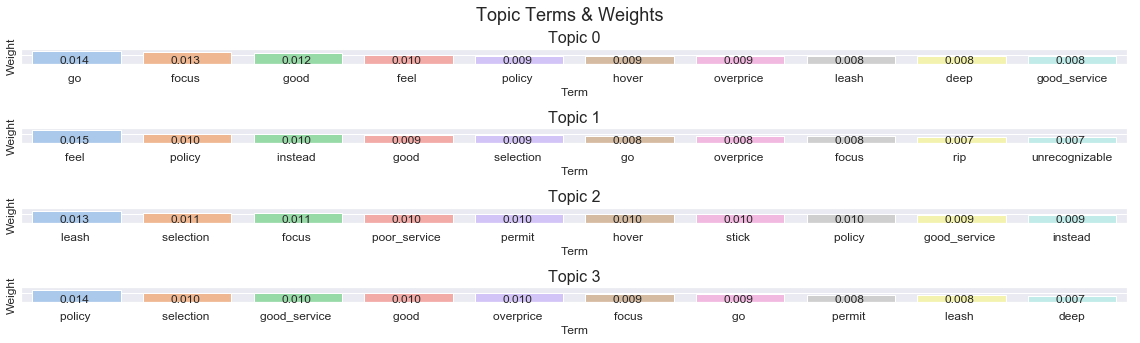

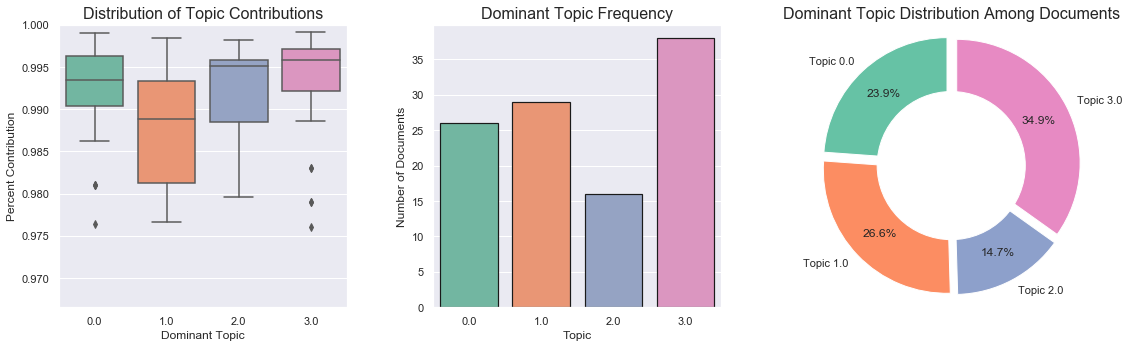

,Topic_%_Contribution,Topic_Keywords,Most_Representative_Text
Topic,,,
0.0,0.9990,"go, focus, good, feel, policy, hover, overprice, leash, deep, good_service",This was my favorite restaurant. But not anymore. Today is my Birthday & thanks to them my day i...
1.0,0.9984,"feel, policy, instead, good, selection, go, overprice, focus, rip, unrecognizable",We decided to visit this place while in the area based on all of the strong reviews from our fel...
2.0,0.9982,"leash, selection, focus, poor_service, permit, hover, stick, policy, good_service, instead",Postino is normally one of our favorite local spots to grab a drink and some dinner. Last night ...
3.0,0.9991,"policy, selection, good_service, good, overprice, focus, go, permit, leash, deep","I won't even venture to guess why so many people like this place. But a few notes: no, it is not..."


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.031500  0.009589       1        1  38.586361
0     -0.001757 -0.031986       2        1  26.262947
1     -0.019248  0.014077       3        1  19.141466
2     -0.010495  0.008320       4        1  16.009233, topic_info=     Category       Freq            Term      Total  loglift  logprob
term                                                                 
28    Default  41.000000            feel  41.000000  30.0000  30.0000
448   Default  23.000000    poor_service  23.000000  29.0000  29.0000
220   Default  38.000000           leash  38.000000  28.0000  28.0000
301   Default  18.000000            door  18.000000  27.0000  27.0000
96    Default  33.000000           hover  33.000000  26.0000  26.0000
286   Default  16.000000          update  16.000000  25.0000  25.0000
98    Default  36.000000         instead  36.000000  24.0000  24.0000
30    Default  13.000000        intimacy  13.000000  23.0000  23.0000
324   Default   8.000000        winecafe   8.000000  22.0000  22.0000
117   Default  30.000000             rip  30.000000  21.0000  21.0000
204   Default  30.000000           stick  30.000000  20.0000  20.0000
88    Default  47.000000           focus  47.000000  19.0000  19.0000
524   Default  20.000000             end  20.000000  18.0000  18.0000
265   Default  36.000000          permit  36.000000  17.0000  17.0000
151   Default  18.000000    combinations  18.000000  16.0000  16.0000
60    Default  42.000000       selection  42.000000  15.0000  15.0000
108   Default  18.000000           peace  18.000000  14.0000  14.0000
8     Default  46.000000              go  46.000000  13.0000  13.0000
25    Default  11.000000             din  11.000000  12.0000  12.0000
107   Default  14.000000            past  14.000000  11.0000  11.0000
3     Default  15.000000          better  15.000000  10.0000  10.0000
689   Default  14.000000          guests  14.000000   9.0000   9.0000
356   Default   7.000000    postino_time   7.000000   8.0000   8.0000
439   Default   7.000000          nearly   7.000000   7.0000   7.0000
101   Default   8.000000            june   8.000000   6.0000   6.0000
50    Default  22.000000  unrecognizable  22.000000   5.0000   5.0000
127   Default  17.000000           table  17.000000   4.0000   4.0000
116   Default   7.000000           relax   7.000000   3.0000   3.0000
67    Default  14.000000         arcadia  14.000000   2.0000   2.0000
320   Default   9.000000            type   9.000000   1.0000   1.0000
...       ...        ...             ...        ...      ...      ...
151    Topic4   4.774408    combinations  18.284067   0.4892  -5.0418
204    Topic4   7.085580           stick  30.441187   0.3743  -4.6470
732    Topic4   1.684507            loaf   4.841013   0.7764  -6.0836
96     Topic4   7.414689           hover  33.729248   0.3171  -4.6016
117    Topic4   6.688711             rip  30.814400   0.3044  -4.7046
296    Topic4   2.284585            blow   7.216424   0.6818  -5.7789
265    Topic4   7.581686          permit  36.836121   0.2513  -4.5793
107    Topic4   3.689663            past  14.296780   0.4775  -5.2995
60     Topic4   7.883272       selection  42.543438   0.1462  -4.5403
98     Topic4   6.723608         instead  36.780300   0.1327  -4.6994
88     Topic4   7.815615           focus  47.343254   0.0307  -4.5489
67     Topic4   3.647576         arcadia  14.329998   0.4637  -5.3110
94     Topic4   6.800458    good_service  40.410896   0.0499  -4.6881
127    Topic4   4.012287           table  17.411844   0.3642  -5.2157
23     Topic4   4.430058       bruchetta  21.853970   0.2360  -5.1166
110    Topic4   7.059298          policy  52.139290  -0.1676  -4.6507
537    Topic4   2.621136           guest   9.317423   0.5637  -5.6415
661    Topic4   2.264660         systems   7.258572   0.6672  -5.7876
317    Topic4   4.540741      seamlessly  26.880476   0.0537  -

In [67]:
#show topics and metrics
print('Individual Business - Negative Reviews (Trigrams)')
lda_metrics(pipeline=negative_lda_pipeline,
            lda_model=sample_negative_lda,
            review_text=sample_negative_reviews,
            test_size=1,
            n_topics=4,
            n_words=10)

#show pyLDAvis figure
sample_negative_vis

### LDA Pipeline - Random Individual Business - Positive Review Results
***
[Top](#Table-of-Contents)

In [68]:
#fit positive lda pipeline to sample business
sample_positive_lda, sample_positive_vis = positive_lda_pipeline.fit_transform(
                                                      sample_business.business_id.iloc[0]
                                                                               )

#get reviews used in lda model
sample_positive_reviews = positive_lda_pipeline.named_steps['selector']\
                                               .transform(sample_business.business_id.iloc[0]
                                                          )

c:\programdata\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Individual Business - Positive Reviews (Trigrams)

Variational Bound: -41914
Log Perplexity: -9.082
Coherence Score: 0.536
Coherence Per Topic
Topic 2: 0.594
Topic 0: 0.543
Topic 1: 0.540
Topic 3: 0.466


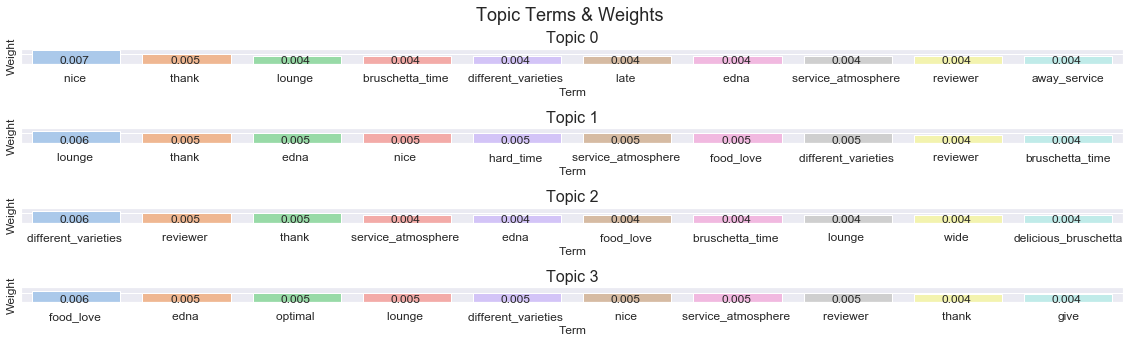

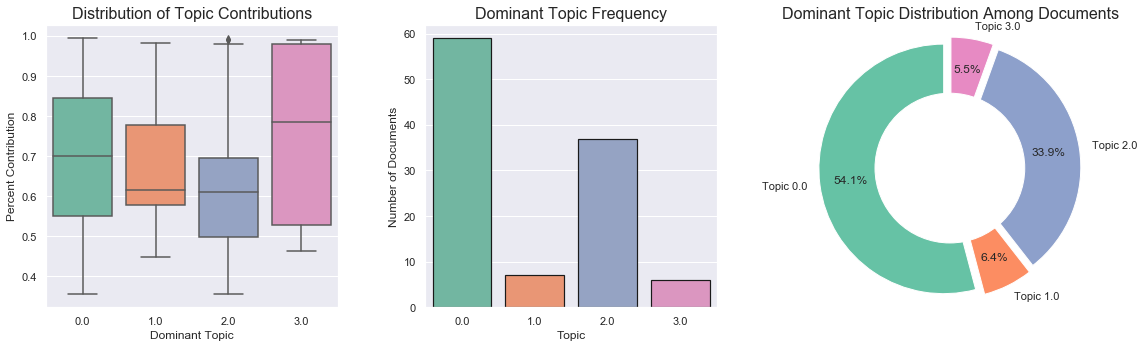

,Topic_%_Contribution,Topic_Keywords,Most_Representative_Text
Topic,,,
0.0,0.9959,"nice, thank, lounge, bruschetta_time, different_varieties, late, edna, service_atmosphere, revie...","Visiting Postino Wine Cafe makes me feel like I am in another city... an urban, metro, pedestria..."
1.0,0.9831,"lounge, thank, edna, nice, hard_time, service_atmosphere, food_love, different_varieties, review...",Nothing worth writing about except the bruschetta. Most of the wine tastes like cheap box wine a...
2.0,0.9924,"different_varieties, reviewer, thank, service_atmosphere, edna, food_love, bruschetta_time, loun...",I came here to meet a friend who I hadn't seen in ages. Some how the waitress assumed we just ne...
3.0,0.9911,"food_love, edna, optimal, lounge, different_varieties, nice, service_atmosphere, reviewer, thank...",Food was ok bread was stale on my sandwich. But service was not good at all! God for bid you ask...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.019894  0.024758       1        1  28.540998
1     -0.028184  0.007613       2        1  25.453085
2      0.014363 -0.023222       3        1  23.299770
0     -0.006073 -0.009148       4        1  22.706146, topic_info=     Category        Freq                  Term       Total  loglift  logprob
term                                                                         
105   Default  154.000000                  nice  154.000000  30.0000  30.0000
51    Default   49.000000            bottomless   49.000000  29.0000  29.0000
834   Default   14.000000                 couch   14.000000  28.0000  28.0000
403   Default   75.000000                  give   75.000000  27.0000  27.0000
208   Default   85.000000              treasure   85.000000  26.0000  26.0000
163   Default   32.000000                highly   32.000000  25.0000  25.0000
1341  Default   24.000000                 learn   24.000000  24.0000  24.0000
99    Default  105.000000             hard_time  105.000000  23.0000  23.0000
178   Default   38.000000             wine_list   38.000000  22.0000  22.0000
8     Default   83.000000                 enjoy   83.000000  21.0000  21.0000
1087  Default   13.000000        chicken_panini   13.000000  20.0000  20.0000
211   Default   48.000000                  away   48.000000  19.0000  19.0000
1275  Default   14.000000                toasty   14.000000  18.0000  18.0000
343   Default   12.000000                   get   12.000000  17.0000  17.0000
332   Default   39.000000                entree   39.000000  16.0000  16.0000
574   Default   20.000000               sangria   20.000000  15.0000  15.0000
442   Default   76.000000                 watch   76.000000  14.0000  14.0000
104   Default   25.000000                  menu   25.000000  13.0000  13.0000
374   Default   30.000000           people_come   30.000000  12.0000  12.0000
824   Default    5.000000          trip_postino    5.000000  11.0000  11.0000
2067  Default    4.000000                rotate    4.000000  10.0000  10.0000
175   Default   24.000000               sundays   24.000000   9.0000   9.0000
381   Default   31.000000                 haven   31.000000   8.0000   8.0000
159   Default   82.000000                  wide   82.000000   7.0000   7.0000
615   Default   26.000000              get_star   26.000000   6.0000   6.0000
413   Default   39.000000                  nerd   39.000000   5.0000   5.0000
185   Default    7.000000         sandwich_huge    7.000000   4.0000   4.0000
522   Default   15.000000                inside   15.000000   3.0000   3.0000
738   Default   55.000000               zealand   55.000000   2.0000   2.0000
480   Default   96.000000                  late   96.000000   1.0000   1.0000
...       ...         ...                   ...         ...      ...      ...
648    Topic4   22.696852                  even   82.276390   0.1947  -5.7362
579    Topic4   30.935459       bruschetta_time  128.237396   0.0606  -5.4265
211    Topic4   15.451952                  away   48.477036   0.3392  -6.1207
264    Topic4   13.265807                trendy   39.499516   0.3914  -6.2732
336    Topic4   33.912582                 thank  148.813400   0.0036  -5.3346
167    Topic4    7.187533              specials   16.738655   0.6372  -6.8861
323    Topic4   16.389359             literally   54.395035   0.2829  -6.0618
699    Topic4   23.190086          salami_pesto   91.898384   0.1056  -5.7147
98     Topic4   20.652885      great_bruschetta   78.164413   0.1516  -5.8306
501    Topic4   25.910461          away_service  111.045929   0.0272  -5.6038
438    Topic4   24.850588          lunch_dinner  104.475639   0.0465  -5.6456
294    Topic4   31.122477                lounge  150.543259  -0.0938  -5.4205
296    Topic4   14.280311             multitude   47.381851   0.2832  -6.1996
92     Topic4   29.957336   different_varieti

In [69]:
#show topics and metrics
print('Individual Business - Positive Reviews (Trigrams)')
lda_metrics(pipeline=positive_lda_pipeline,
            lda_model=sample_positive_lda,
            review_text=sample_negative_reviews,
            test_size=1,
            n_topics=4,
            n_words=10)

#show pyLDAvis figure
sample_positive_vis

## LDA Pipeline - Food Industry
- [Negative Review Results](#LDA-Pipeline---Food-Industry---Negative-Review-Results)
- [Positive Review Results](#LDA-Pipeline---Food-Industry---Positive-Review-Results)
***
[Top](#Table-of-Contents)

In [106]:
#build pipeline to create LDA topic model from text series
lda_pipeline = Pipeline([
                        #tokenize, normalize, remove stop words, and create lemmas 
                        # - create trigrams from phrases in at least 5 documents, and a score of 1
                        ('preprocessor', Preprocess(trigrams=True,
                                                    min_count=5,
                                                    threshold=1)),
                        #vectorize
                        # - remove the top 3 tokens
                        # - remove tokens with less than 10 occurrences
                        ('vectorizer', Vectorize(filter_no_below=10,
                                                 filter_n_freq=3)),
                        #train lda model on corpus
                        # - create pyLDAvis figure
                        ('lda_model', LDA_Estimator(visualize=True))
                         ])

In [107]:
'''split food industry reviews into training and test sets
    - this can be done because each dataset is large enough,
      with hundreds of thousands of negative reviews and over a million positive reviews
    - not recommended for individual businesses as sample size is typically small (<20,000)
'''
nr_train, nr_test = train_test_split(negative_reviews.text, test_size=0.2)
pr_train, pr_test = train_test_split(positive_reviews.text, test_size=0.2)

In [108]:
#fit training reviews to pipeline
negative_trigrams_lda, negative_trigrams_vis = lda_pipeline.fit_transform(nr_train)
positive_trigrams_lda, positive_trigrams_vis = lda_pipeline.fit_transform(pr_train)

c:\programdata\anaconda3\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
c:\programdata\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### LDA Pipeline - Food Industry - Negative Review Results
***
[Top](#Table-of-Contents)

Food Industry - Negative Reviews (Trigrams)

Variational Bound: -5452816
Log Perplexity: -11.207
Coherence Score: 0.542
Coherence Per Topic
Topic 6: 0.668
Topic 3: 0.645
Topic 9: 0.578
Topic 2: 0.563
Topic 4: 0.553
Topic 0: 0.544
Topic 7: 0.474
Topic 1: 0.471
Topic 8: 0.470
Topic 5: 0.454


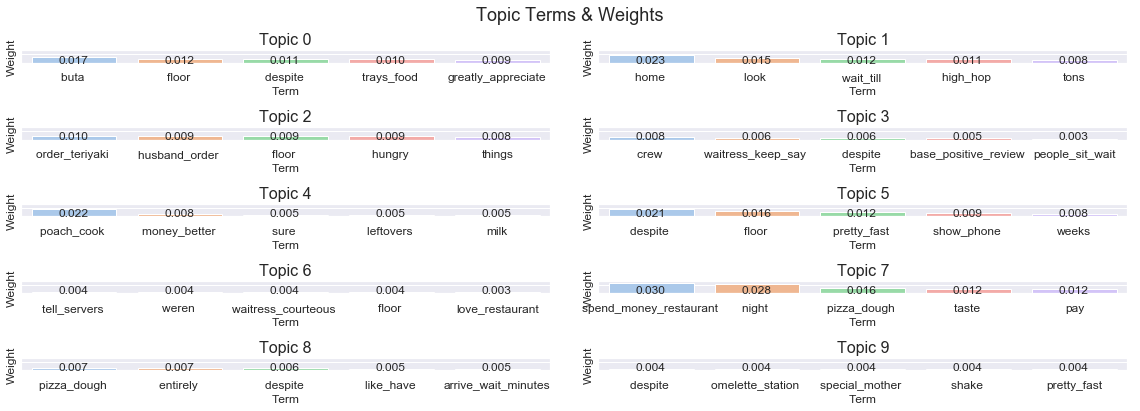

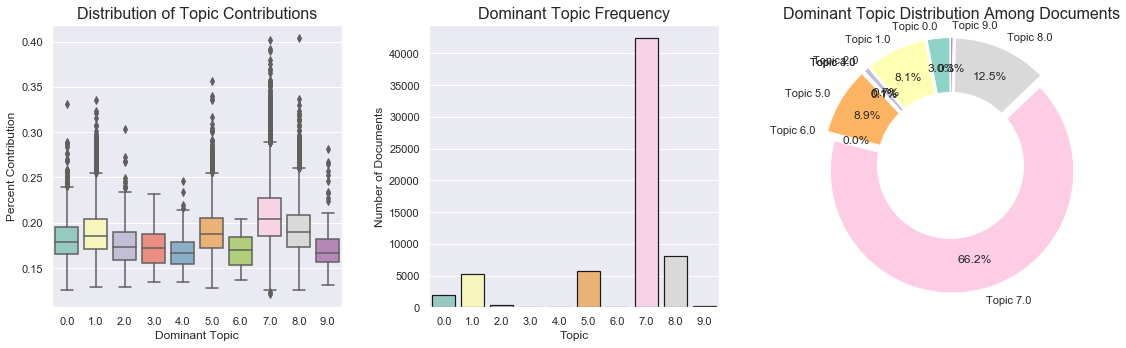

,Topic_%_Contribution,Topic_Keywords,Most_Representative_Text
Topic,,,
0.0,0.3308,"buta, floor, despite, trays_food, greatly_appreciate, selections, manager_run, greet, decently_f...","Always on the top of the Brunch list, I had to try it, to my dismay, it did not live up to it's ..."
1.0,0.3360,"home, look, wait_till, high_hop, tons, slam_check, place_try_hard, despite, waitress_come_table,...","Server was a straight bitch , didn't add my blazin rewards after I personally gave her my number..."
2.0,0.3039,"order_teriyaki, husband_order, floor, hungry, things, night, shift, service_food_good, despite, ...","Originally, I would have rated them five stars because I thought their food was awesome. At the..."
3.0,0.2315,"crew, waitress_keep_say, despite, base_positive_review, people_sit_wait, potato, price_match, pr...","Ahhh, Grimaldis, I love you so...BUT you really disappointed me today. We were at the mall with..."
4.0,0.2456,"poach_cook, money_better, sure, leftovers, milk, home, chinese_mexican_food, waitress_come_table...",So this Italian Restaurant was on my to do wish list so I finally gave it a try and I was dissap...
5.0,0.3568,"despite, floor, pretty_fast, show_phone, weeks, poorly, specifically_state, couple_time, case, t...","I used to love coming here, the smell of someone else's Gandhi would trigger my own urge to get ..."
6.0,0.2046,"tell_servers, weren, waitress_courteous, floor, love_restaurant, lack_authenticity, especially, ...",Oyster specials were good and meaty for $2.50 each.\n\nI came here to try the Live Lobster pho t...
7.0,0.4020,"spend_money_restaurant, night, pizza_dough, taste, pay, hop, horrible, food_inconsistent, high_h...",There are a lot of high reviews and 5 stars for this place and I am confused as to why. I in no ...
8.0,0.4044,"pizza_dough, entirely, despite, like_have, arrive_wait_minutes, serve, stone_cold, pay, waitress...","Avant de commencer, je dois dire que je ne connais rien Ã la cuisine polonaise et que ce restau..."


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.210001 -0.039165       1        1  23.465736
5     -0.120176 -0.073319       2        1  15.165180
8      0.207404 -0.019447       3        1  13.353628
1      0.097777 -0.046211       4        1  10.657062
0     -0.210461 -0.101313       5        1   9.841204
2     -0.209660 -0.109236       6        1   8.000923
9      0.101860  0.016917       7        1   5.616961
3     -0.021501 -0.013165       8        1   4.973133
4      0.060251  0.035237       9        1   4.839989
6     -0.115496  0.349702      10        1   4.086185, topic_info=      Category          Freq                    Term         Total  loglift  \
term                                                                          
30     Default  73099.000000  spend_money_restaurant  73099.000000  30.0000   
56     Default  15542.000000                    buta  15542.000000  29.0000   
112    Default  37767.000000                    home  37767.000000  28.0000   
21     Default  74449.000000                   night  74449.000000  27.0000   
534    Default   9261.000000              poach_cook   9261.000000  26.0000   
45     Default  33064.000000                high_hop  33064.000000  25.0000   
16     Default  19772.000000                    look  19772.000000  24.0000   
182    Default  11190.000000                   weeks  11190.000000  23.0000   
5      Default  49923.000000                   floor  49923.000000  22.0000   
938    Default  19013.000000                stickers  19013.000000  21.0000   
116    Default  32009.000000                     pay  32009.000000  20.0000   
1030   Default   8378.000000              trays_food   8378.000000  19.0000   
814    Default  12928.000000               wait_till  12928.000000  18.0000   
239    Default  10116.000000      specifically_state  10116.000000  17.0000   
11     Default  27081.000000                horrible  27081.000000  16.0000   
386    Default   9684.000000          order_teriyaki   9684.000000  15.0000   
383    Default   6327.000000                  hungry   6327.000000  14.0000   
282    Default   9381.000000                    case   9381.000000  13.0000   
141    Default  14358.000000      greatly_appreciate  14358.000000  12.0000   
1469   Default   7420.000000                    tons   7420.000000  11.0000   
225    Default  33408.000000                     hop  33408.000000  10.0000   
1135   Default   6056.000000              selections   6056.000000   9.0000   
1099   Default   8820.000000              slam_check   8820.000000   8.0000   
585    Default  22042.000000                 orleans  22042.000000   7.0000   
821    Default  12006.000000             manager_run  12006.000000   6.0000   
308    Default  17403.000000           number_people  17403.000000   5.0000   
409    Default  12419.000000           husband_order  12419.000000   4.0000   
62     Default  67416.000000                 despite  67416.000000   3.0000   
1749   Default   5610.000000                   greet   5610.000000   2.0000   
150    Default  33503.000000                   taste  33503.000000   1.0000   
...        ...           ...                     ...           ...      ...   
505    Topic10    780.217041       dessert_selection    782.699768   3.1944   
9552   Topic10    628.763306            couple_group    629.411316   3.1965   
1857   Topic10   1191.675293              especially   1201.556274   3.1893   
1870   Topic10    580.114258            italian_food    580.710999   3.1965   
2320   Topic10    507.371155         come_california    507.858459   3.1966   
46361  Topic10    491.643921     absolutely_dreadful    492.003174   3.1968   
12783  Topic10    501.246277          great_location    501.722534   3.1966   
6196   Topic10    520.095703            steak_shrimp    520.887878   3.1960   
29887  Topic10    479.171082      servers_unfriendly    479.513947   3

In [57]:
#view topics and scores
print('Food Industry - Negative Reviews (Trigrams)')
lda_metrics(pipeline=lda_pipeline,
            lda_model=negative_trigrams_lda,
            review_text=nr_test,
            test_size=0.2,
            n_topics=10,
            n_words=5)

#visualize negative trigrams lda topics
negative_trigrams_vis

### LDA Pipeline - Food Industry - Positive Review Results
***
[Top](#Table-of-Contents)

Food Industry - Positive Reviews (Trigrams)

Variational Bound: -16619774
Log Perplexity: -11.544
Coherence Score: 0.525
Coherence Per Topic
Topic 5: 0.598
Topic 4: 0.582
Topic 0: 0.550
Topic 1: 0.549
Topic 2: 0.544
Topic 7: 0.521
Topic 9: 0.503
Topic 3: 0.476
Topic 6: 0.476
Topic 8: 0.456


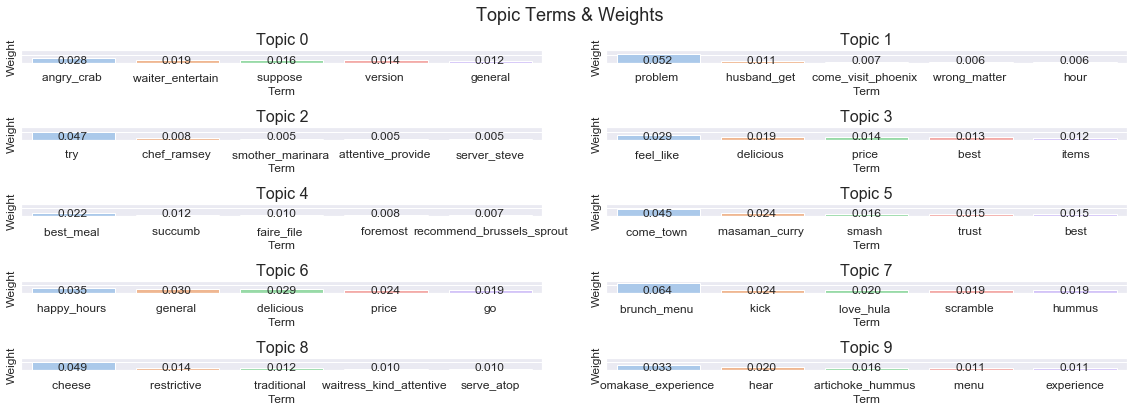

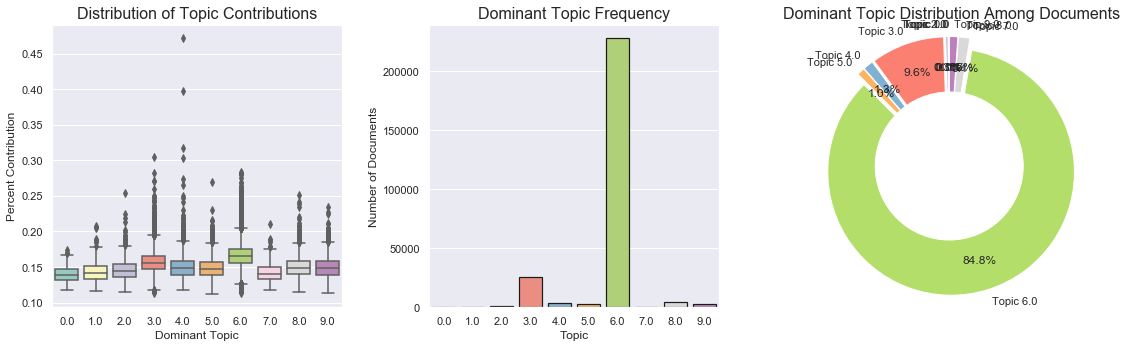

,Topic_%_Contribution,Topic_Keywords,Most_Representative_Text
Topic,,,
0.0,0.1744,"angry_crab, waiter_entertain, suppose, version, general, chef_ramsey, surely, original, price, c...",Its a bit difficult to say if the food here is any good or not. I'm writing this review while go...
1.0,0.2078,"problem, husband_get, come_visit_phoenix, wrong_matter, hour, menu, quality_quantity, nutella_ba...",I came in on thursday to order a 50th anniversary cake. The lady helping me was friendly and he...
2.0,0.2538,"try, chef_ramsey, smother_marinara, attentive_provide, server_steve, north_phoenix, boyfriend_ta...",The atmosphere is really elegant at this place especially at the top floor. Our server did a rea...
3.0,0.3052,"feel_like, delicious, price, best, items, run, meat_combo_platter, cheese, second_night, toast","Famous Daves... Famous Daves....\nYes, I know a few.\n\nDavid Lynch \nDavid Cassidy \nDavid Bore..."
4.0,0.4726,"best_meal, succumb, faire_file, foremost, recommend_brussels_sprout, dress, artichoke_hummus, fe...","Buffet-Restaurants haben fast alle Hotels in Las Vegas. Im teuren Vegas eine MÃ¶glichkeit, gut u..."
5.0,0.2690,"come_town, masaman_curry, smash, trust, best, rito, flavorful, ahead_time, delicious, hand","I am no expert on soul food, but the fried chicken is finger lickin' good. Please don't sue me, ..."
6.0,0.2841,"happy_hours, general, delicious, price, go, plastic_bag, say_hour_wait, food_general, feel_like,...","This is definitely the best bar in the area. It has a ton of British charm, European and domesti..."
7.0,0.2109,"brunch_menu, kick, love_hula, scramble, hummus, kinda_slow, remind_mexican, potato_casserole, fe...",I totally agree with the other Yelpers! It is the best authentic Chinese food in Vegas. Prices...
8.0,0.2511,"cheese, restrictive, traditional, waitress_kind_attentive, serve_atop, taste, crisp_fresh, best,...",Sunday at Noon and we were able to get a table immediately even though it was a packed house. F...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.119830 -0.069814       1        1  18.179382
3     -0.148745  0.142629       2        1  12.749126
9      0.063878 -0.144363       3        1  10.636566
8     -0.187844  0.023770       4        1  10.398151
5     -0.185453 -0.032961       5        1  10.003176
4      0.184049 -0.035683       6        1   9.193238
7      0.005722  0.257815       7        1   8.442364
1     -0.038780 -0.298086       8        1   7.488491
0      0.116901  0.179270       9        1   6.744989
2      0.310103 -0.022577      10        1   6.164520, topic_info=      Category           Freq                   Term          Total  loglift  \
term                                                                           
76     Default  157777.000000            brunch_menu  157777.000000  30.0000   
114    Default  105236.000000                problem  105236.000000  29.0000   
125    Default  206422.000000                 cheese  206422.000000  28.0000   
66     Default  145238.000000              come_town  145238.000000  27.0000   
327    Default   84455.000000                    try   84455.000000  26.0000   
22     Default  110475.000000     omakase_experience  110475.000000  25.0000   
46     Default  228541.000000            happy_hours  228541.000000  24.0000   
83     Default  249658.000000              delicious  249658.000000  23.0000   
213    Default   53204.000000                   kick   53204.000000  22.0000   
56     Default   69138.000000          masaman_curry   69138.000000  21.0000   
142    Default   56705.000000             angry_crab   56705.000000  20.0000   
1252   Default   55820.000000                   hear   55820.000000  19.0000   
155    Default  219390.000000              feel_like  219390.000000  18.0000   
216    Default   50253.000000              love_hula   50253.000000  17.0000   
412    Default   65085.000000              best_meal   65085.000000  16.0000   
369    Default   42664.000000               scramble   42664.000000  15.0000   
1107   Default   41231.000000                 hummus   41231.000000  14.0000   
991    Default   40405.000000             kinda_slow   40405.000000  13.0000   
4      Default  113030.000000                   best  113030.000000  12.0000   
1031   Default   33971.000000       waiter_entertain   33971.000000  11.0000   
92     Default   83886.000000           food_general   83886.000000  10.0000   
279    Default   37811.000000                   rito   37811.000000   9.0000   
623    Default   33805.000000         remind_mexican   33805.000000   8.0000   
241    Default   65987.000000       artichoke_hummus   65987.000000   7.0000   
189    Default   73241.000000                  smash   73241.000000   6.0000   
1585   Default   41150.000000            restrictive   41150.000000   5.0000   
93     Default  239999.000000                general  239999.000000   4.0000   
27     Default   38197.000000           second_night   38197.000000   3.0000   
113    Default   31318.000000       potato_casserole   31318.000000   2.0000   
135    Default   95618.000000                  trust   95618.000000   1.0000   
...        ...            ...                    ...            ...      ...   
6059   Topic10    2148.257812             club_snack    2150.531494   2.7853   
112    Topic10    1787.244141       pork_belly_fatty    1787.662720   2.7861   
3236   Topic10    1778.456421              hopefully    1778.808472   2.7862   
432    Topic10    4564.880859                    din    4618.347168   2.7747   
1448   Topic10    1857.474976                gnocchi    1860.164551   2.7849   
327    Topic10   75540.726562                    try   84455.312500   2.6748   
2214   Topic10    2350.656494      jumbo_bake_potato    2370.450439   2.7780   
67     Topic10    4008.711182           fast_service    4125.248047   2.7577   
11464  Topic10    3447.660645

In [127]:
#view topics and scores
print('Food Industry - Positive Reviews (Trigrams)')
lda_metrics(pipeline=lda_pipeline,
            lda_model=positive_trigrams_lda,
            review_text=pr_test,
            test_size=0.2,
            n_topics=10,
            n_words=5)

#visualize positive trigrams lda topics
positive_trigrams_vis